In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
from datetime import datetime
import os
import re
import matplotlib # Graphical Visualisation
import matplotlib.pyplot as plt
import matplotlib.dates as pltdt
import matplotlib.image as mpimg
import matplotlib.patches
from math import sqrt,pi,sin,cos,atan2
from sklearn import linear_model
from sklearn import metrics

In [2]:
# Importing Data

In [3]:
df = pd.read_csv('scraps6.csv')
df.head()

id                                              title  \
0  3350  Vente appartement 2 pièces 55 m² Toulouse (313...   
1  3349  Vente appartement 3 pièces 71 m² Toulouse (312...   
2  3348  Vente appartement 2 pièces 58 m² Toulouse (310...   
3  3347  Vente appartement 5 pièces 120 m² Toulouse (31...   
4  3346     Vente maison 140 m² Toulouse (31300) 490.000 €   

                                                link      price  \
0  https://www.pap.fr/annonces/appartement-toulou...  249.000 €   
1  https://www.pap.fr/annonces/appartement-toulou...  300.000 €   
2  https://www.pap.fr/annonces/appartement-toulou...  335.000 €   
3  https://www.pap.fr/annonces/appartement-toulou...  475.000 €   
4  https://www.pap.fr/annonces/maison-toulouse-31...  490.000 €   

                          ref_n_date              city  \
0  Réf. : D66/1857 / 08 juillet 2021  Toulouse (31000)   
1  Réf. : D70/0145 / 08 juillet 2021  Toulouse (31200)   
2  Réf. : D70/2010 / 08 juillet 2021  Toulouse (31000)   
3  Réf. : D70/1941 / 08 juillet 2021  Toulouse (31500)   
4  Réf. : D71/2202 / 08 juillet 2021  Toulouse (31300)   

                                                tags  \
0             2 pièces 1 chambre 55 m² 4.527 € le m²   
1            3 pièces 2 chambres 71 m² 4.225 € le m²   
2             2 pièces 1 chambre 58 m² 5.776 € le m²   
3           5 pièces 4 chambres 120 m² 3.958 € le m²   
4  5 pièces 3 chambres 140 m² Terrain 292 m² 3.50...   

                                           free_text  transport  \
0  Toulouse (31000) 2 pièces 1 chambre 55 m² 4.52...        NaN   
1  Toulouse (31200) 3 pièces 2 chambres 71 m² 4.2...        NaN   
2  Toulouse (31000) 2 pièces 1 chambre 58 m² 5.77...        NaN   
3  Toulouse (31500) 5 pièces 4 chambres 120 m² 3....        NaN   
4  Toulouse (31300) 5 pièces 3 chambres 140 m² Te...        NaN   

                                         raw_loc                   createdAt  \
0  {"center":["43.595082","1.415804"],"zoom":15}  2021-07-09 23:51:35.925+02   
1  {"center":["43.637652","1.452544"],"zoom":15}  2021-07-09 23:51:26.802+02   
2  {"center":["43.604647","1.441086"],"zoom":15}  2021-07-09 23:51:20.707+02   
3  {"center":["43.623197","1.460017"],"zoom":15}  2021-07-09 23:51:15.606+02   
4  {"center":["43.580837","1.424641"],"zoom":15}  2021-07-09 23:51:11.502+02   

                    updatedAt  
0  2021-07-09 23:51:35.925+02  
1  2021-07-09 23:51:26.802+02  
2  2021-07-09 23:51:20.707+02  
3  2021-07-09 23:51:15.606+02  
4  2021-07-09 23:51:11.502+02

In [4]:
# Cleaning Data

In [5]:
len(df)

3286

In [6]:
df = df.drop(columns='id')

df['raw_loc'] = df['raw_loc'].map(lambda x : x.lstrip('{"center":['))
df['raw_loc'] = df['raw_loc'].map(lambda x : x.rstrip('],"zoom":15}'))
df['lat'] = df['raw_loc'].map(lambda x : x.split(',')[0])
df['long'] = df['raw_loc'].map(lambda x : x.split(',')[1])

df = df.drop(columns=['raw_loc'])

df['lat'] = df['lat'].map(lambda x : x.rstrip('"'))
df['long'] = df['long'].map(lambda x : x.lstrip('"'))
df['long'] = df['long'].map(lambda x : x.replace(']', ''))
df['lat'] = pd.to_numeric(df['lat'])
df['long'] = pd.to_numeric(df['long'])

df['tags'] = df['tags'].map(lambda x : x.replace('\n\n\n', ','))
df['tags'] = df['tags'].map(lambda x : x.replace('\n\n', ''))


df['ref'] = df['ref_n_date'].map(lambda x : x.split(' / ')[0])
df['date'] = df['ref_n_date'].map(lambda x : x.split(' / ')[1])

df = df.drop(columns=['ref_n_date'])

df = df.drop_duplicates(subset=['ref'], keep='last')

df['price'] = df['price'].map(lambda x : x.replace('.', ''))
df['price'] = df['price'].map(lambda x : x.rstrip(' €'))
df['price'] = df['price'].map(lambda x : x.rstrip())
df['price'] = pd.to_numeric(df['price'])

df['free_text'] = df['free_text'].apply(lambda x : x.rstrip(" Une erreur est survenue. Veuillez essayer de nouveau. Votre prénom Veuillez indiquer votre prénom. Ce prénom est trop long. Votre nom Veuillez indiquer votre nom. Ce nom est trop long. Votre e-mail Veuillez indiquer votre adresse e-mail. Cette adresse e-mail est incorrecte. Cette adresse e-mail est trop longue. Votre téléphone Veuillez saisir votre numéro de téléphone. Ce numéro de téléphone est incorrect. Votre message (pensez à donner des précisions sur votre recherche et sur votre plan de financement : emprunt, accord de principe de la banque, revente d'un bien...) / caractères Veuillez indiquer un message. Ce message est trop long. Envoi en cours... Message envoyé avec succès ! J'autorise pap.fr à collecter, traiter et transmettre ces données à l'annonceur. En savoir plus Votre prénom Veuillez indiquer votre prénom. Ce prénom est trop long. Votre nom Veuillez indiquer votre nom. Ce nom est trop long. Votre e-mail Veuillez indiquer votre adresse e-mail. Cette adresse e-mail est incorrecte. Cette adresse e-mail est trop longue. Votre téléphone Veuillez saisir votre numéro de téléphone. Ce numéro de téléphone est incorrect. Votre message (pensez à donner des précisions sur votre recherche et sur votre plan de financement : emprunt, accord de principe de la banque, revente d'un bien...) / caractères Veuillez indiquer un message. Ce message est trop long. Simulation de financement Prix du bien : Prix + Frais de notaire (indicatif) : Apport personnel : L'apport personnel doit être un entier Emprunt : Veuillez indiquer un montant d'emprunt Taux d'intérêt* : Veuillez indiquer un taux. Taux d'assurance* : Durée Mensualité Coût de l'emprunt 10 15 20 25 30 Comparer les offres de financement Prix du bien : Prix + Frais de notaire (indicatif) : Taux d'intérêt* : Veuillez indiquer un taux. Taux d'assurance* :"))

df = df.reset_index(drop=True)

In [7]:
pieces = []
chambre = []
sqrt_mtr = []

i = 0
while i <= len(df)-1:
    ext = df['tags'][i]
    pieces_toadd = ''    
    chambre_toadd = ''
    sqrt_mtr_toadd = ''
    
    try :
        pieces_toadd = re.findall('(\d+)[^\d]+pièce[s]?', ext)[0]
    except :
        pieces_toadd = ''
    
    try :
        chambre_toadd = re.findall('(\d+)[^\d]+chambre[s]?', ext)[0]
    except : 
        chambre_toadd = ''
        
    try : 
        sqrt_mtr_toadd = re.findall('(\d+)[^\d]+m²', ext)[0]
    except : 
        sqrt_mtr_toadd = ''
    
    if pieces_toadd == '':
        pieces.append('')
    else:
        pieces.append(pieces_toadd)
    
    if chambre_toadd == '':
        chambre.append('')
    else:
        chambre.append(chambre_toadd)
        
    if sqrt_mtr_toadd == '':
        sqrt_mtr.append('')
    else:
        sqrt_mtr.append(sqrt_mtr_toadd)
        
    i = i + 1

df['pieces'] = pieces
df['chambre'] = chambre
df['sqrt_meter'] = sqrt_mtr

df = df.drop(columns=['tags'])

df['price'] = pd.to_numeric(df['price'])
df['sqrt_meter'] = pd.to_numeric(df['sqrt_meter'])
df['pieces'] = pd.to_numeric(df['pieces'])
df['chambre'] = pd.to_numeric(df['chambre'])

df['mean_price_sqrtmtr'] = df['price'] / df['sqrt_meter']

In [8]:
marque_1 = []
cave = []
balcon = []
parking = []
chambre = []

x = 0
while x <= len(df)-1:
    ft1 = ''
    ft1 = df['free_text'][x]
    ft1 = str(ft1)
    c = re.findall('étage | etage', ft1.lower())#[0].title())
    if not c:
        marque_1.append(0)
    else:
        marque_1.append(1)
        
    ft2 = ''
    ft2 = df['free_text'][x]
    ft2 = str(ft2)
    c = re.findall('cave', ft2.lower())#[0].title())
    if not c:
        cave.append(0)
    else:
        cave.append(1)
        
    ft3 = ''
    ft3 = df['free_text'][x]
    ft3 = str(ft3)
    c = re.findall('balcon | terrasse', ft3.lower())#[0].title())
    if not c:
        balcon.append(0)
    else:
        balcon.append(1)
        
    ft4 = ''
    ft4 = df['free_text'][x]
    ft4 = str(ft4)
    c = re.findall('chambre', ft4.lower())#[0].title())
    if not c:
        chambre.append(0)
    else:
        chambre.append(1)
        
    ft5 = ''
    ft5 = df['free_text'][x]
    ft5 = str(ft5)
    c = re.findall('parking', ft5.lower())#[0].title())
    if not c:
        parking.append(0)
    else:
        parking.append(1)
    
    x = x +1
    
df['cave'] = cave
df['balcon'] = balcon
df['parking'] = parking
df['chambre'] = chambre

In [9]:
def calculate_distance(x, y):
    xa = x
    ya = y
    xb = 2.256520
    yb = 48.896801
    r = 6371e3
    
    a1 = xa * pi/180
    a2 = xb * pi/180
    v1 = (xb-xa) * pi/180
    v2 = (yb-ya) * pi/180
    
    a = sin(v1/2) * sin(v1/2) +cos(a1) * cos(a2) * sin(v2/2) * sin(v2/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = (r * c) / 1000

    return d

distance = []
x = 0
while x <= len(df)-1:
    a = calculate_distance(df['long'][x], df['lat'][x])
    
    distance.append(a)
    x = x + 1
    
df['distance'] = distance

In [10]:
def text_to_date(x):
    day = int(x[0:2])
    month = x[3:-5]
    
    if month == 'mai':
        mth = 5
    elif month == 'août':
        mth = 8
    elif month == 'juin':
        mth = 6
    elif month == 'juillet':
        mth = 7
    
    year = int(x[-4:])
    
    date = datetime(year, mth, day)
    date = date.strftime('%d/%m/%Y')
    
    return date

In [11]:
df['code-postal'] = df['city'].apply(lambda x : x[-8:])
df['code-postal'] = df['code-postal'].apply(lambda x : x.replace('(', ''))
df['code-postal'] = df['code-postal'].apply(lambda x : x.replace(')', ''))
df['city'] = df['city'].apply(lambda x : x[:-8])
df['date'] = df['date'].apply(lambda x : text_to_date(x))
#df['date'] = pd.to_numeric(df['date'])
df['sqrt_meter'] = pd.to_numeric(df['sqrt_meter'], downcast='integer')
df['sqrt_meter'] = df['sqrt_meter'].fillna(0)
df['sqrt_meter'] = df['sqrt_meter'].apply(lambda x : int(x))

df = df.loc[df['price'] > 0 ,:]
df = df.loc[df['sqrt_meter'] > 0 ,:]
df = df.reset_index(drop=True)

In [12]:
df['price'].value_counts()

320000     10
350000      8
495000      8
255000      8
390000      7
           ..
1985000     1
422500      1
880000      1
374000      1
1130000     1
Name: price, Length: 353, dtype: int64

In [13]:
df.head()

title  \
0     Vente maison 138 m² Toulouse (31200) 494.000 €   
1  Vente appartement 4 pièces 83 m² Toulouse (310...   
2  Vente appartement 3 pièces 50 m² Toulouse (312...   
3  Vente appartement 4 pièces 95 m² Toulouse (310...   
4  Vente appartement 2 pièces 30 m² Toulouse (313...   

                                                link   price      city  \
0  https://www.pap.fr/annonces/maison-toulouse-31...  494000  Toulouse   
1  https://www.pap.fr/annonces/appartement-toulou...  369000  Toulouse   
2  https://www.pap.fr/annonces/appartement-toulou...  253000  Toulouse   
3  https://www.pap.fr/annonces/appartement-toulou...  565000  Toulouse   
4  https://www.pap.fr/annonces/appartement-toulou...  120000  Toulouse   

                                           free_text  transport  \
0  Toulouse (31200) 5 pièces 4 chambres 138 m² Te...        NaN   
1  Toulouse (31000) 4 pièces 3 chambres 83 m² 4.4...        NaN   
2  Toulouse (31000) 3 pièces 2 chambres 50 m² 5.0...        NaN   
3  Toulouse (31000) 4 pièces 3 chambres 95 m² 5.9...        NaN   
4  Toulouse (31300) 2 pièces 1 chambre 30 m² 4.00...        NaN   

                    createdAt                   updatedAt        lat  \
0  2021-07-09 23:42:39.727+02  2021-07-09 23:42:39.727+02  43.660005   
1  2021-07-09 23:41:26.394+02  2021-07-09 23:41:26.394+02  43.612119   
2  2021-07-09 23:41:17.291+02  2021-07-09 23:41:17.291+02  43.616971   
3  2021-07-09 23:39:44.821+02  2021-07-09 23:39:44.821+02  43.605186   
4  2021-07-09 23:39:34.712+02  2021-07-09 23:39:34.712+02  43.611688   

       long  ...        date pieces  chambre  sqrt_meter  mean_price_sqrtmtr  \
0  1.436433  ...  05/07/2021    5.0        1         138         3579.710145   
1  1.451790  ...  06/07/2021    4.0        1          83         4445.783133   
2  1.442698  ...  06/07/2021    3.0        1          50         5060.000000   
3  1.425472  ...  08/07/2021    4.0        1          95         5947.368421   
4  1.394127  ...  08/07/2021    2.0        1          30         4000.000000   

   cave  balcon  parking    distance  code-postal  
0     0       1        0  589.098230        31200  
1     0       1        1  594.094590        31000  
2     0       0        0  593.716149        31000  
3     1       1        1  595.307545        31000  
4     0       1        1  595.150034        31300  

[5 rows x 21 columns]

In [14]:
# EDA

<i>Creating Dataset based on City level</i>

In [15]:
city_general_characteristics = pd.DataFrame({
    "city" : [],
    "count" : [],
    "mean_sqrt_meter" : [],
    "min_sqrt_meter" : [],
    "max_sqrt_meter" : [],
    "median_sqrt_meter" : [],
    "mean_price" : [],
    "min_price" : [],
    "max_price" : [],
    "median_price" : [],
    "mean_price_sqrtmtr" : []
})

count = df['city'].count()
mean_sqrt_meter = df['sqrt_meter'].mean()
min_sqrt_meter = df['sqrt_meter'].min()
max_sqrt_meter = df['sqrt_meter'].max()
median_sqrt_meter = df['sqrt_meter'].median()
mean_price = df['price'].mean()
min_price = df['price'].min()
max_price = df['price'].max()
median_price = df['price'].median()
mean_price_sqrt = df['mean_price_sqrtmtr'].mean()

r = city_general_characteristics.shape[0]
city_general_characteristics.loc[r] = ['General',count,mean_sqrt_meter,min_sqrt_meter,max_sqrt_meter,median_sqrt_meter,mean_price,min_price,max_price,median_price, mean_price_sqrt]

for x in set(df['city']):
    temp = df.loc[df['city']==x,:]
    
    city = x
    
    count = temp['city'].count()
    mean_sqrt_meter = temp['sqrt_meter'].mean()
    min_sqrt_meter = temp['sqrt_meter'].min()
    max_sqrt_meter = temp['sqrt_meter'].max()
    median_sqrt_meter = temp['sqrt_meter'].median()
    mean_price = temp['price'].mean()
    min_price = temp['price'].min()
    max_price = temp['price'].max()
    median_price = temp['price'].median()
    mean_price_sqrt = temp['mean_price_sqrtmtr'].mean()
    
    r = city_general_characteristics.shape[0]
    city_general_characteristics.loc[r] = [city,count,mean_sqrt_meter,min_sqrt_meter,max_sqrt_meter,median_sqrt_meter,mean_price,min_price,max_price,median_price,mean_price_sqrt]
    
city_general_characteristics

city  count  mean_sqrt_meter  min_sqrt_meter  \
0                     General  755.0        71.488742             7.0   
1                  Bouguenais    1.0        88.000000            88.0   
2                     Orvault    3.0       101.333333            75.0   
3       Ramonville-Saint-Agne    4.0        88.500000            63.0   
4                     Couëron    1.0        94.000000            94.0   
5                        Rezé    4.0        75.250000            57.0   
6                     Cugnaux    2.0        91.000000            88.0   
7                      Bouaye    2.0        60.500000            26.0   
8              Saint-Herblain    4.0        92.500000            49.0   
9                     Puteaux   82.0        69.378049            13.0   
10                   Toulouse  197.0        75.116751            16.0   
11          Quint-Fonsegrives    1.0        78.000000            78.0   
12                      Balma    1.0       113.000000           113.0   
13                  Carquefou    1.0        68.000000            68.0   
14                    Blagnac    6.0        89.833333            60.0   
15                  Beauzelle    1.0       105.000000           105.0   
16                 Aucamville    1.0        45.000000            45.0   
17                   Flourens    1.0       120.000000           120.0   
18          Neuilly-sur-Seine   83.0        69.662651             7.0   
19                   Colombes   23.0        74.652174            40.0   
20        La Garenne-Colombes   37.0        75.000000            28.0   
21                 Courbevoie   99.0        67.686869            18.0   
22                     Nantes   56.0        70.517857            18.0   
23      Sainte-Luce-sur-Loire    2.0        99.000000            80.0   
24                  Colomiers    1.0        44.000000            44.0   
25              Bois-Colombes   23.0        71.086957            24.0   
26           Levallois-Perret   95.0        61.126316            14.0   
27                La Montagne    2.0        76.500000            75.0   
28         Asnières-sur-Seine   17.0        79.882353            34.0   
29                    Ancenis    1.0       140.000000           140.0   
30                     Vertou    1.0        98.000000            98.0   
31          Thouaré-sur-Loire    1.0       126.000000           126.0   
32  Saint-Sébastien-sur-Loire    2.0        61.000000            42.0   

    max_sqrt_meter  median_sqrt_meter     mean_price  min_price  max_price  \
0            175.0               70.0  502976.238411    60000.0  2500000.0   
1             88.0               88.0  285000.000000   285000.0   285000.0   
2            125.0              104.0  357000.000000   252000.0   449000.0   
3            105.0               93.0  290750.000000   215000.0   390000.0   
4             94.0               94.0  270000.000000   270000.0   270000.0   
5             91.0               76.5  236722.500000   172000.0   350000.0   
6             94.0               91.0  310000.000000   280000.0   340000.0   
7             95.0               60.5  222500.000000   110000.0   335000.0   
8            120.0              100.5  317500.000000   185000.0   455000.0   
9            142.0               67.5  581670.731707   175000.0  1269000.0   
10           160.0               70.0  294916.700508    60000.0   850000.0   
11            78.0               78.0  235000.000000   235000.0   235000.0   
12           113.0              113.0  410000.000000   410000.0   410000.0   
13            68.0               68.0  284000.000000   284000.0   284000.0   
14           150.0               83.0  248916.666667   150000.0   470000.0   
15           105.0              105.0  340000.000000   340000.0   340000.0   
16            45.0               45.0  135000.000000   135000.0   135000.0   
17           120.0              120.0  400000.000000   400000.0   400000.0   
18           162.0               68.0  865435.903614    9900

In [16]:
df.describe()

price  transport         lat        long      pieces  \
count  7.550000e+02        0.0  755.000000  755.000000  753.000000   
mean   5.029762e+05        NaN   45.973240    1.598454    3.136786   
std    3.286216e+05        NaN    7.907040    1.149518    1.128046   
min    6.000000e+04        NaN    0.000000   -1.694409    1.000000   
25%    2.700000e+05        NaN   43.620651    1.438250    2.000000   
50%    4.200000e+05        NaN   48.883007    2.240689    3.000000   
75%    6.360000e+05        NaN   48.896421    2.267227    4.000000   
max    2.500000e+06        NaN   48.930994    2.316743    5.000000   

          chambre  sqrt_meter  mean_price_sqrtmtr        cave      balcon  \
count  755.000000  755.000000          755.000000  755.000000  755.000000   
mean     0.927152   71.488742         7254.906309    0.548344    0.454305   
std      0.260059   29.373310         3301.285878    0.497987    0.498238   
min      0.000000    7.000000         1280.487805    0.000000    0.000000   
25%      1.000000   50.000000         4174.969988    0.000000    0.000000   
50%      1.000000   70.000000         7285.714286    1.000000    0.000000   
75%      1.000000   90.000000         9778.911565    1.000000    1.000000   
max      1.000000  175.000000        18048.780488    1.000000    1.000000   

          parking     distance  
count  755.000000   755.000000  
mean     0.511258   355.924865  
std      0.500205   879.281080  
min      0.000000     0.110202  
25%      0.000000     2.107931  
50%      1.000000     3.574203  
75%      1.000000   593.329048  
max      1.000000  5441.385126

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               755 non-null    object 
 1   link                755 non-null    object 
 2   price               755 non-null    int64  
 3   city                755 non-null    object 
 4   free_text           755 non-null    object 
 5   transport           0 non-null      float64
 6   createdAt           755 non-null    object 
 7   updatedAt           755 non-null    object 
 8   lat                 755 non-null    float64
 9   long                755 non-null    float64
 10  ref                 755 non-null    object 
 11  date                755 non-null    object 
 12  pieces              753 non-null    float64
 13  chambre             755 non-null    int64  
 14  sqrt_meter          755 non-null    int64  
 15  mean_price_sqrtmtr  755 non-null    float64
 16  cave    

In [18]:
# °reprocessing
df.isnull().sum()

title                   0
link                    0
price                   0
city                    0
free_text               0
transport             755
createdAt               0
updatedAt               0
lat                     0
long                    0
ref                     0
date                    0
pieces                  2
chambre                 0
sqrt_meter              0
mean_price_sqrtmtr      0
cave                    0
balcon                  0
parking                 0
distance                0
code-postal             0
dtype: int64

title : object
link : object


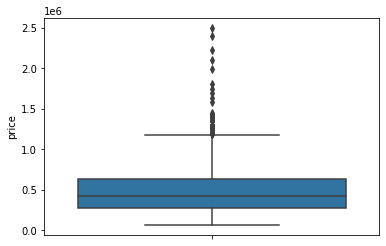

price : int64
city : object
free_text : object


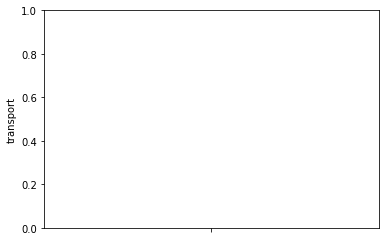

transport : float64
createdAt : object
updatedAt : object


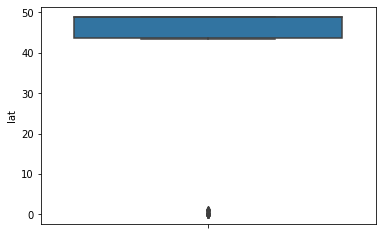

lat : float64


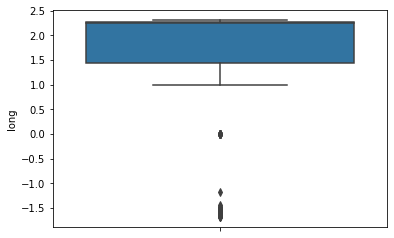

long : float64
ref : object
date : object


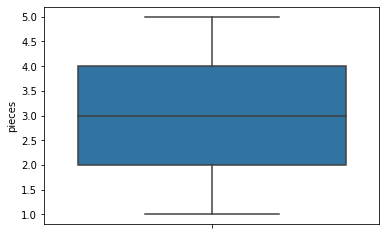

pieces : float64


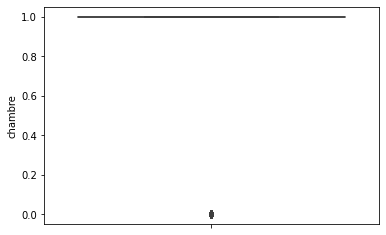

chambre : int64


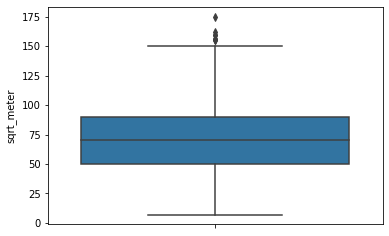

sqrt_meter : int64


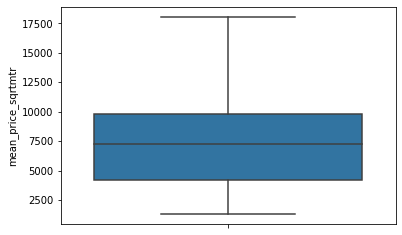

mean_price_sqrtmtr : float64


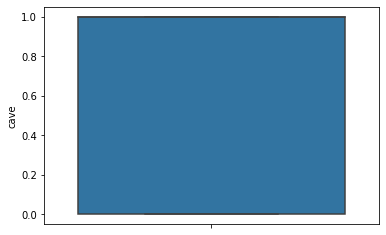

cave : int64


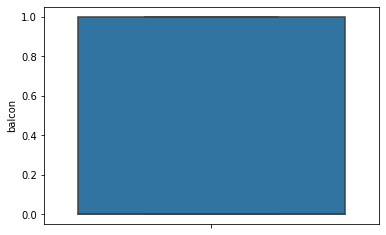

balcon : int64


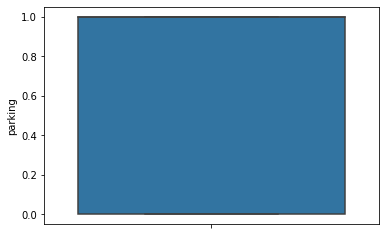

parking : int64


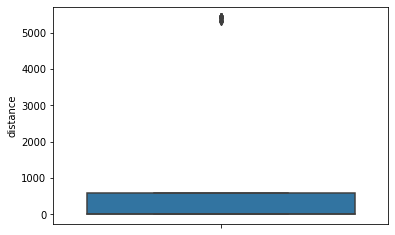

distance : float64
code-postal : object


In [19]:
# EDA 1
for column in df.columns:
    if df[column].dtype == 'int64' or df[column].dtype == 'float64':
        sns.boxplot(y = df[column], data=df )
    plt.show()
    print(f'{column} : {df[column].dtype}')

<BarContainer object of 32 artists>

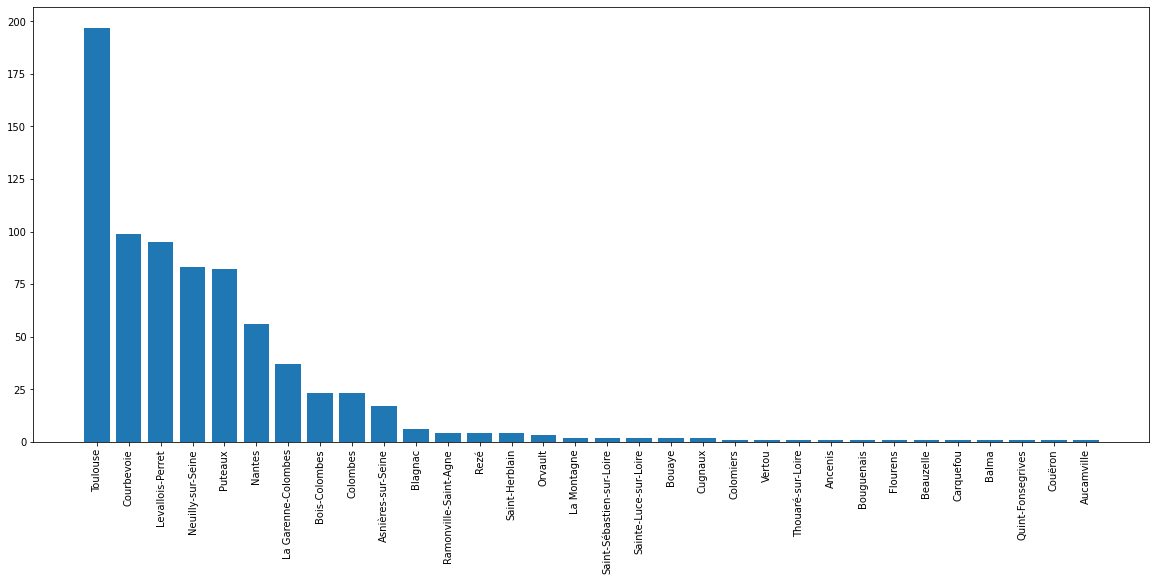

In [20]:
x = df['city'].value_counts().values
y = df['city'].value_counts().index

plt.figure(figsize=(20,8))
plt.xticks(rotation=90)
plt.bar(y,x)

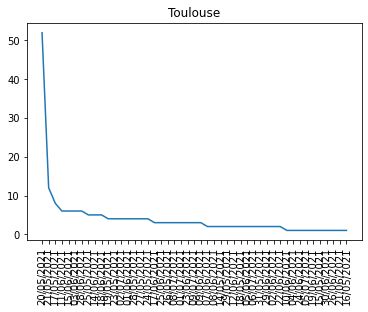

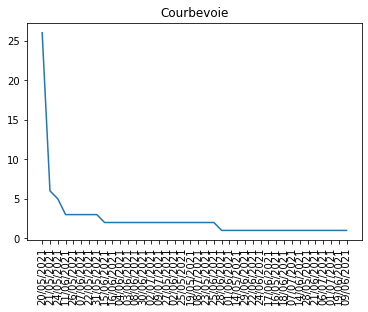

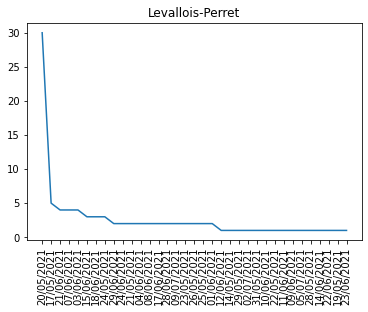

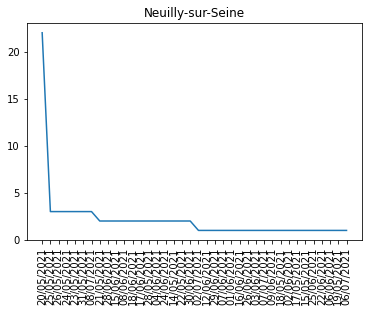

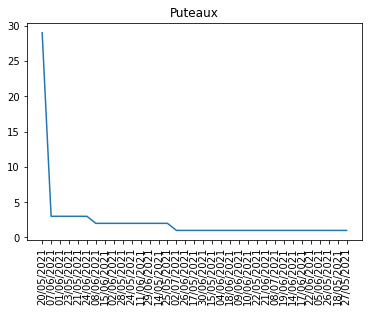

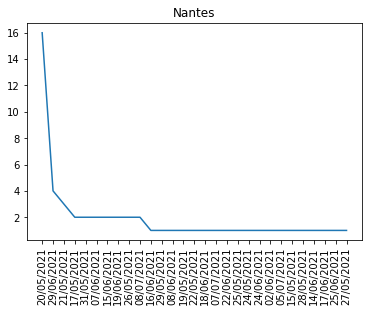

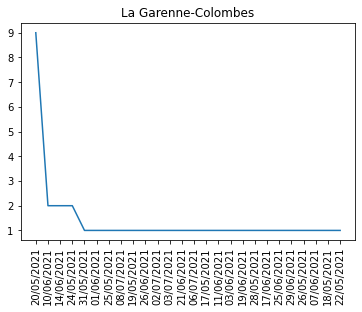

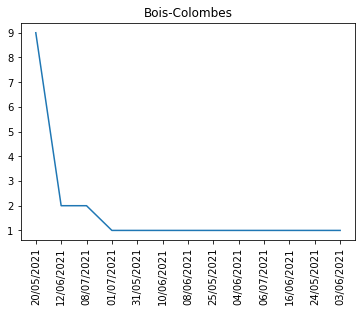

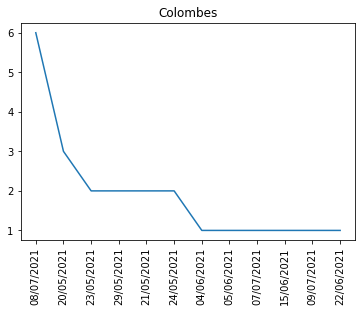

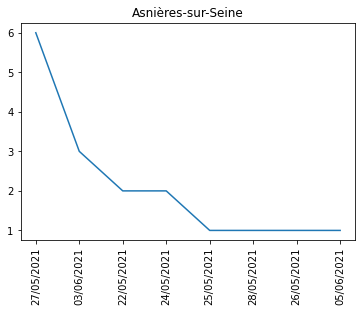

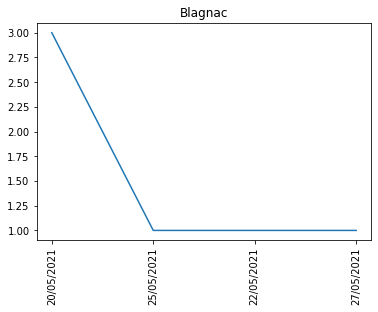

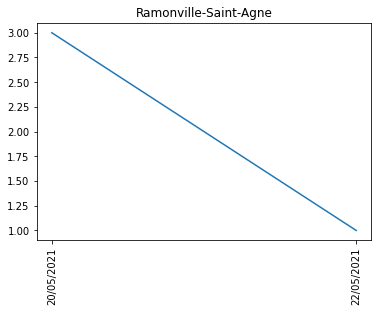

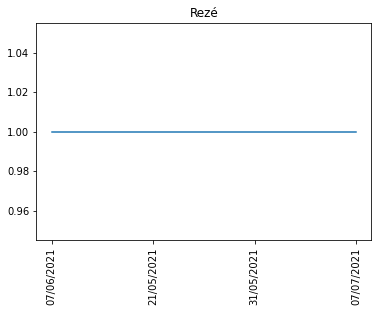

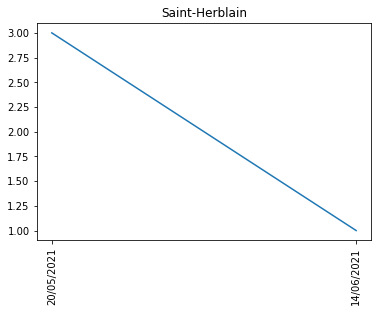

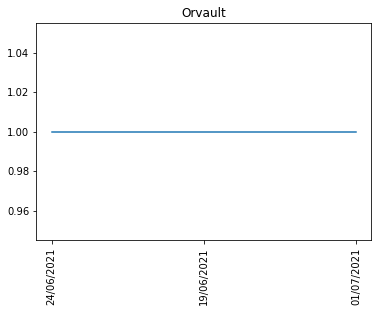

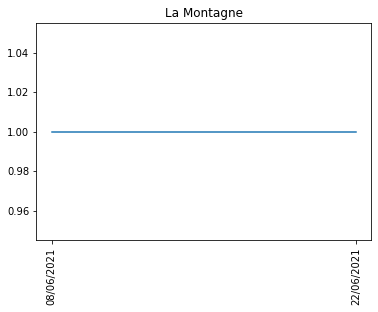

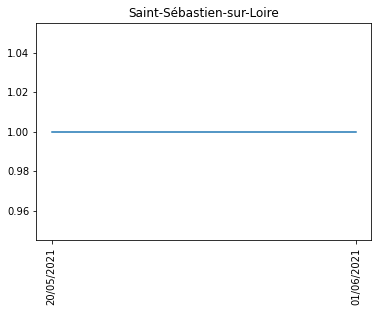

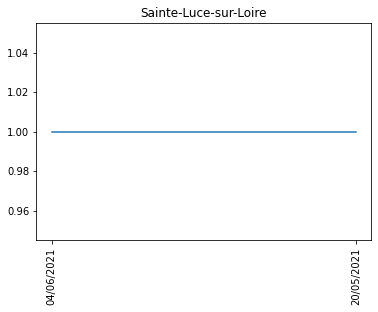

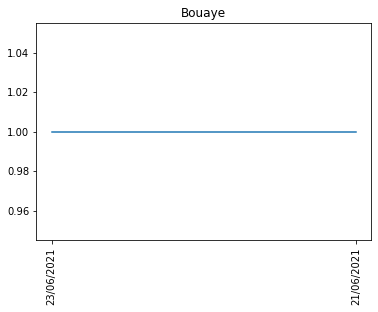

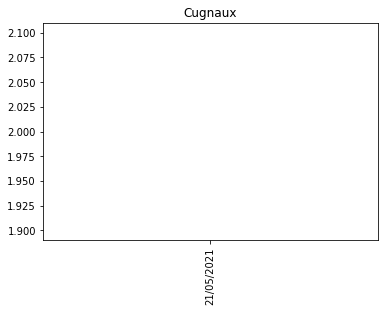

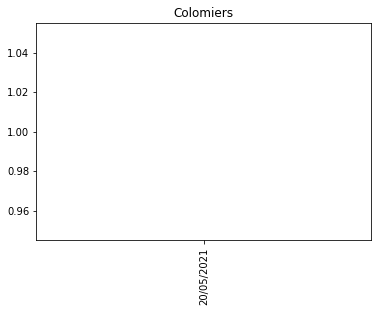

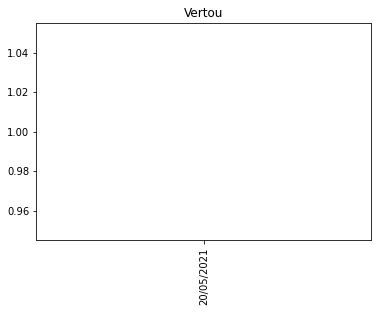

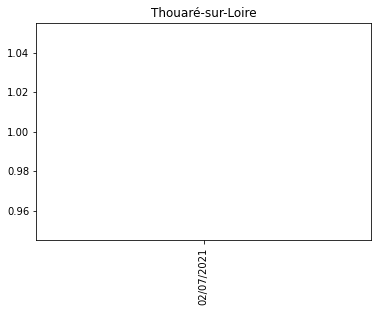

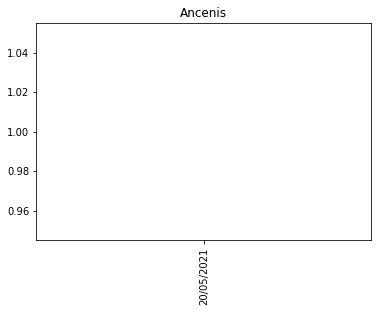

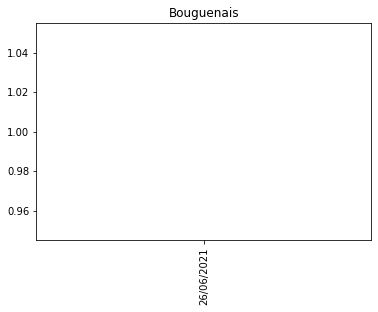

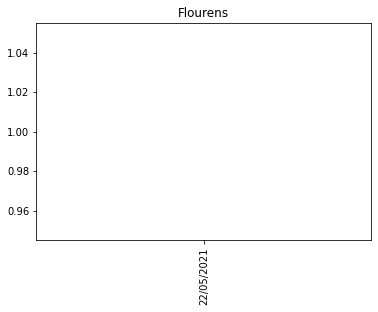

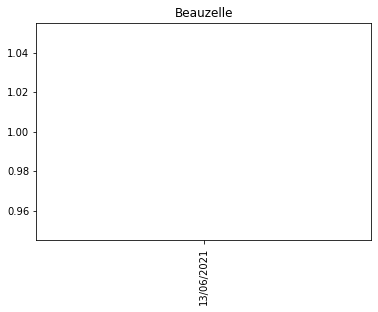

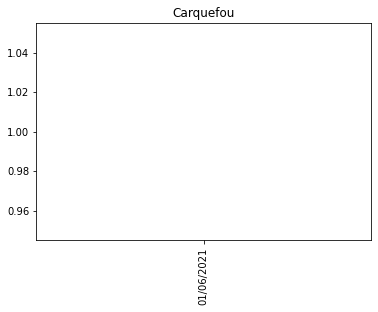

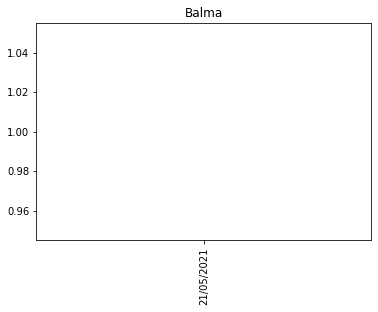

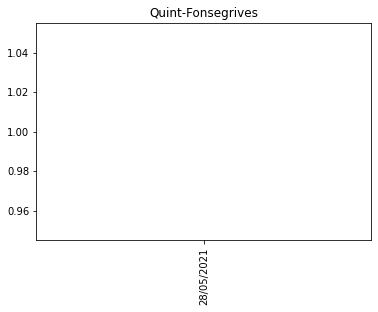

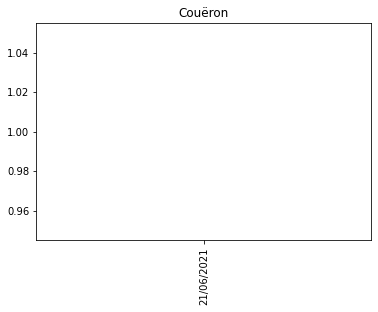

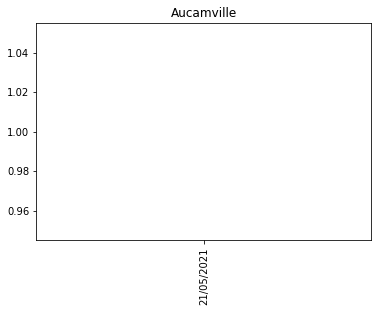

In [21]:
for city in df['city'].value_counts().index:
    scope = df.loc[df['city']==city,:]
    x = scope['date'].value_counts().index
    y = scope['date'].value_counts().values
    plt.plot(x,y)
    plt.title(city)
    plt.xticks(rotation=90)
    plt.show()

#fig, axes = plt.subplots(5, 5, figsize=(16, 8))

#for col, ax in zip(df.columns, axes.flatten()):
#    ax.bar(df.index, df[col])
#    ax.set_title(col)
#    plt.subplots_adjust(wspace=.5, hspace=.5)

In [22]:
df['date'].describe()

count            755
unique            53
top       20/05/2021
freq             210
Name: date, dtype: object

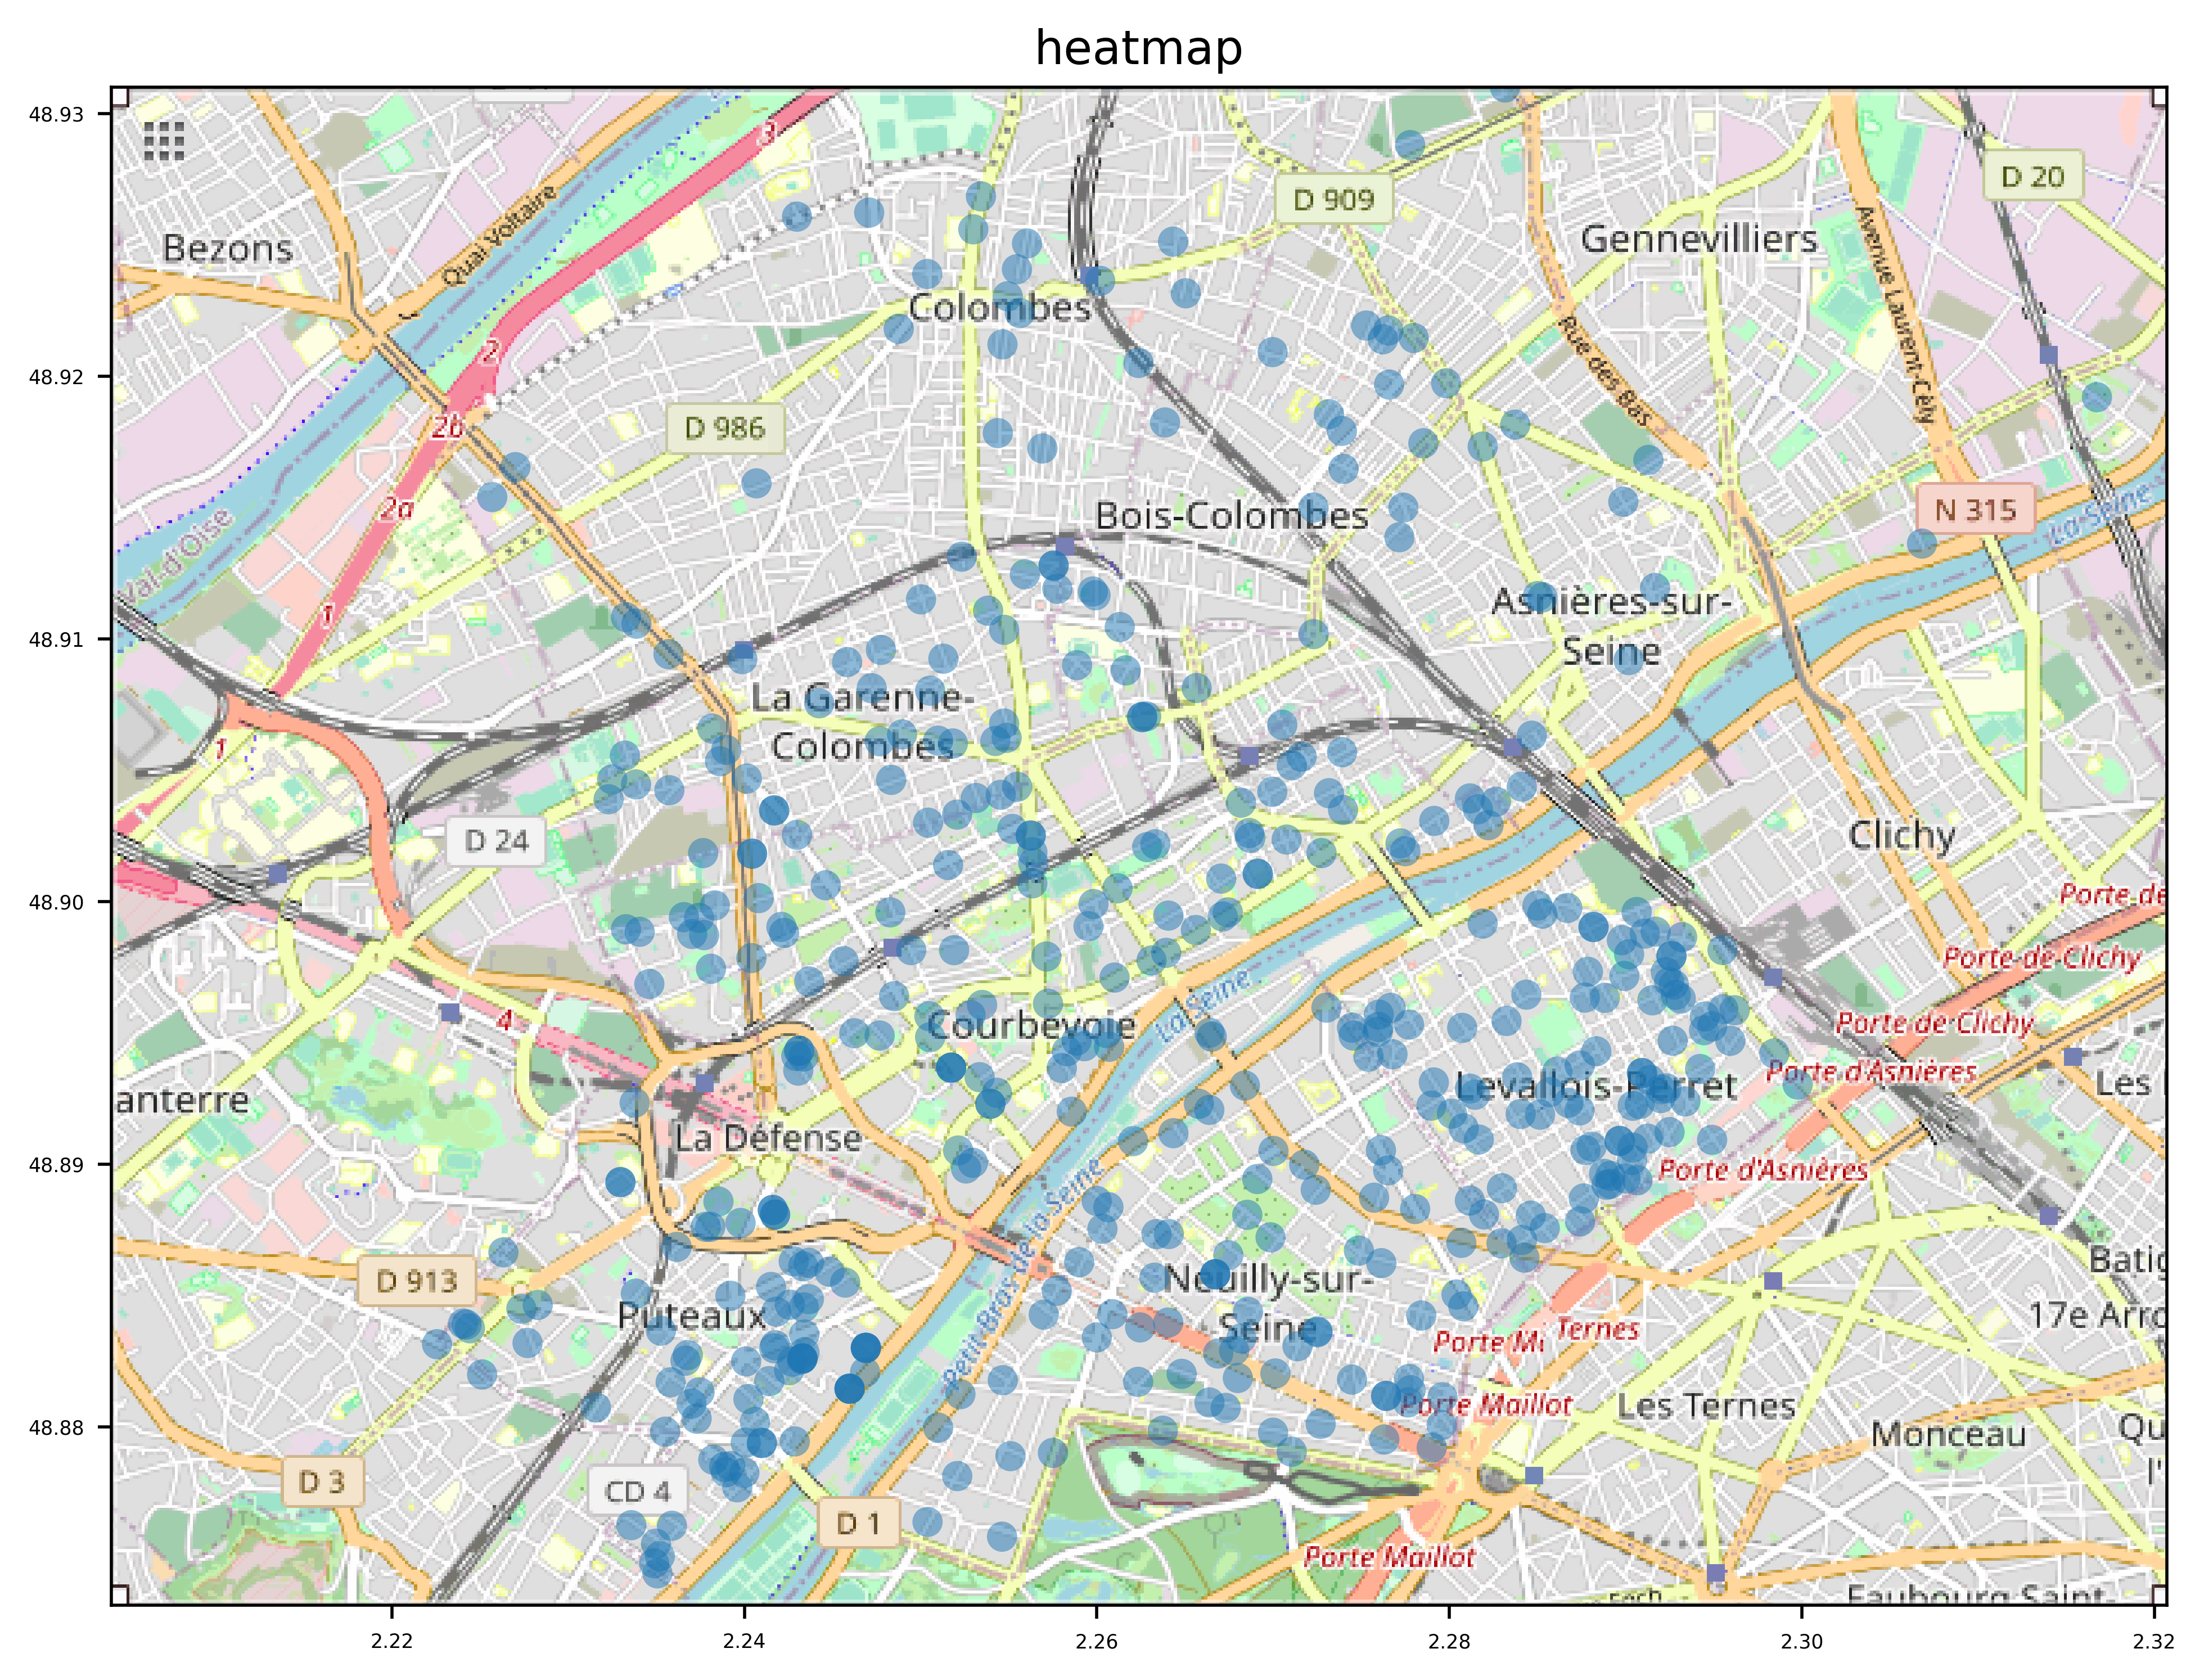

In [23]:
# 48,8732 // 48,9310
# 2.2041 // 2.3207

img=mpimg.imread("map.PNG")

cmap          = matplotlib.cm.get_cmap('YlOrRd')
my_cmap       = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
my_cmap       = matplotlib.colors.ListedColormap(my_cmap)

x_min = 2.2041 #min(df['long']) - 0.100
x_max = 2.3207 #max(df['long']) + 0.100
y_min = 48.8732 #min(df['lat']) - 0.100
y_max = 48.9310 #max(df['lat']) + 0.100

extent = (x_min, x_max, y_min, y_max)

plt.Figure(figsize=(679,515), dpi=50);
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9.43,7.15)
fig.set_dpi(500)
ax = plt.gca()
ax.set_aspect('auto')
plt.title('heatmap');

plt.imshow(img, aspect='auto', extent = extent, cmap='gray') # Comment to remove background

plt.scatter(df['long'], df['lat'], s=60, alpha=0.5, edgecolors='none') # COMMENT TO REMOVE BLUE POINTS
#plt.scatter(df['long'], df['lat'], s=15, alpha=1, edgecolors='none') # COMMENT TO REMOVE ORANGE POINTS
    
plt.xlim((x_min,x_max))
plt.ylim((y_min,y_max))

plt.xticks(size=5)
plt.yticks(size=5)

colormap = np.array(['r', 'g', 'b'])

#plt.scatter(a[0], a[1], s=100, c=colormap[df['mean_price_sqrtmtr']])

#plt.savefig(path + '/heatmaps/' + 'global.png' , transparent=True);
plt.show()
#plt.close()# Mapping

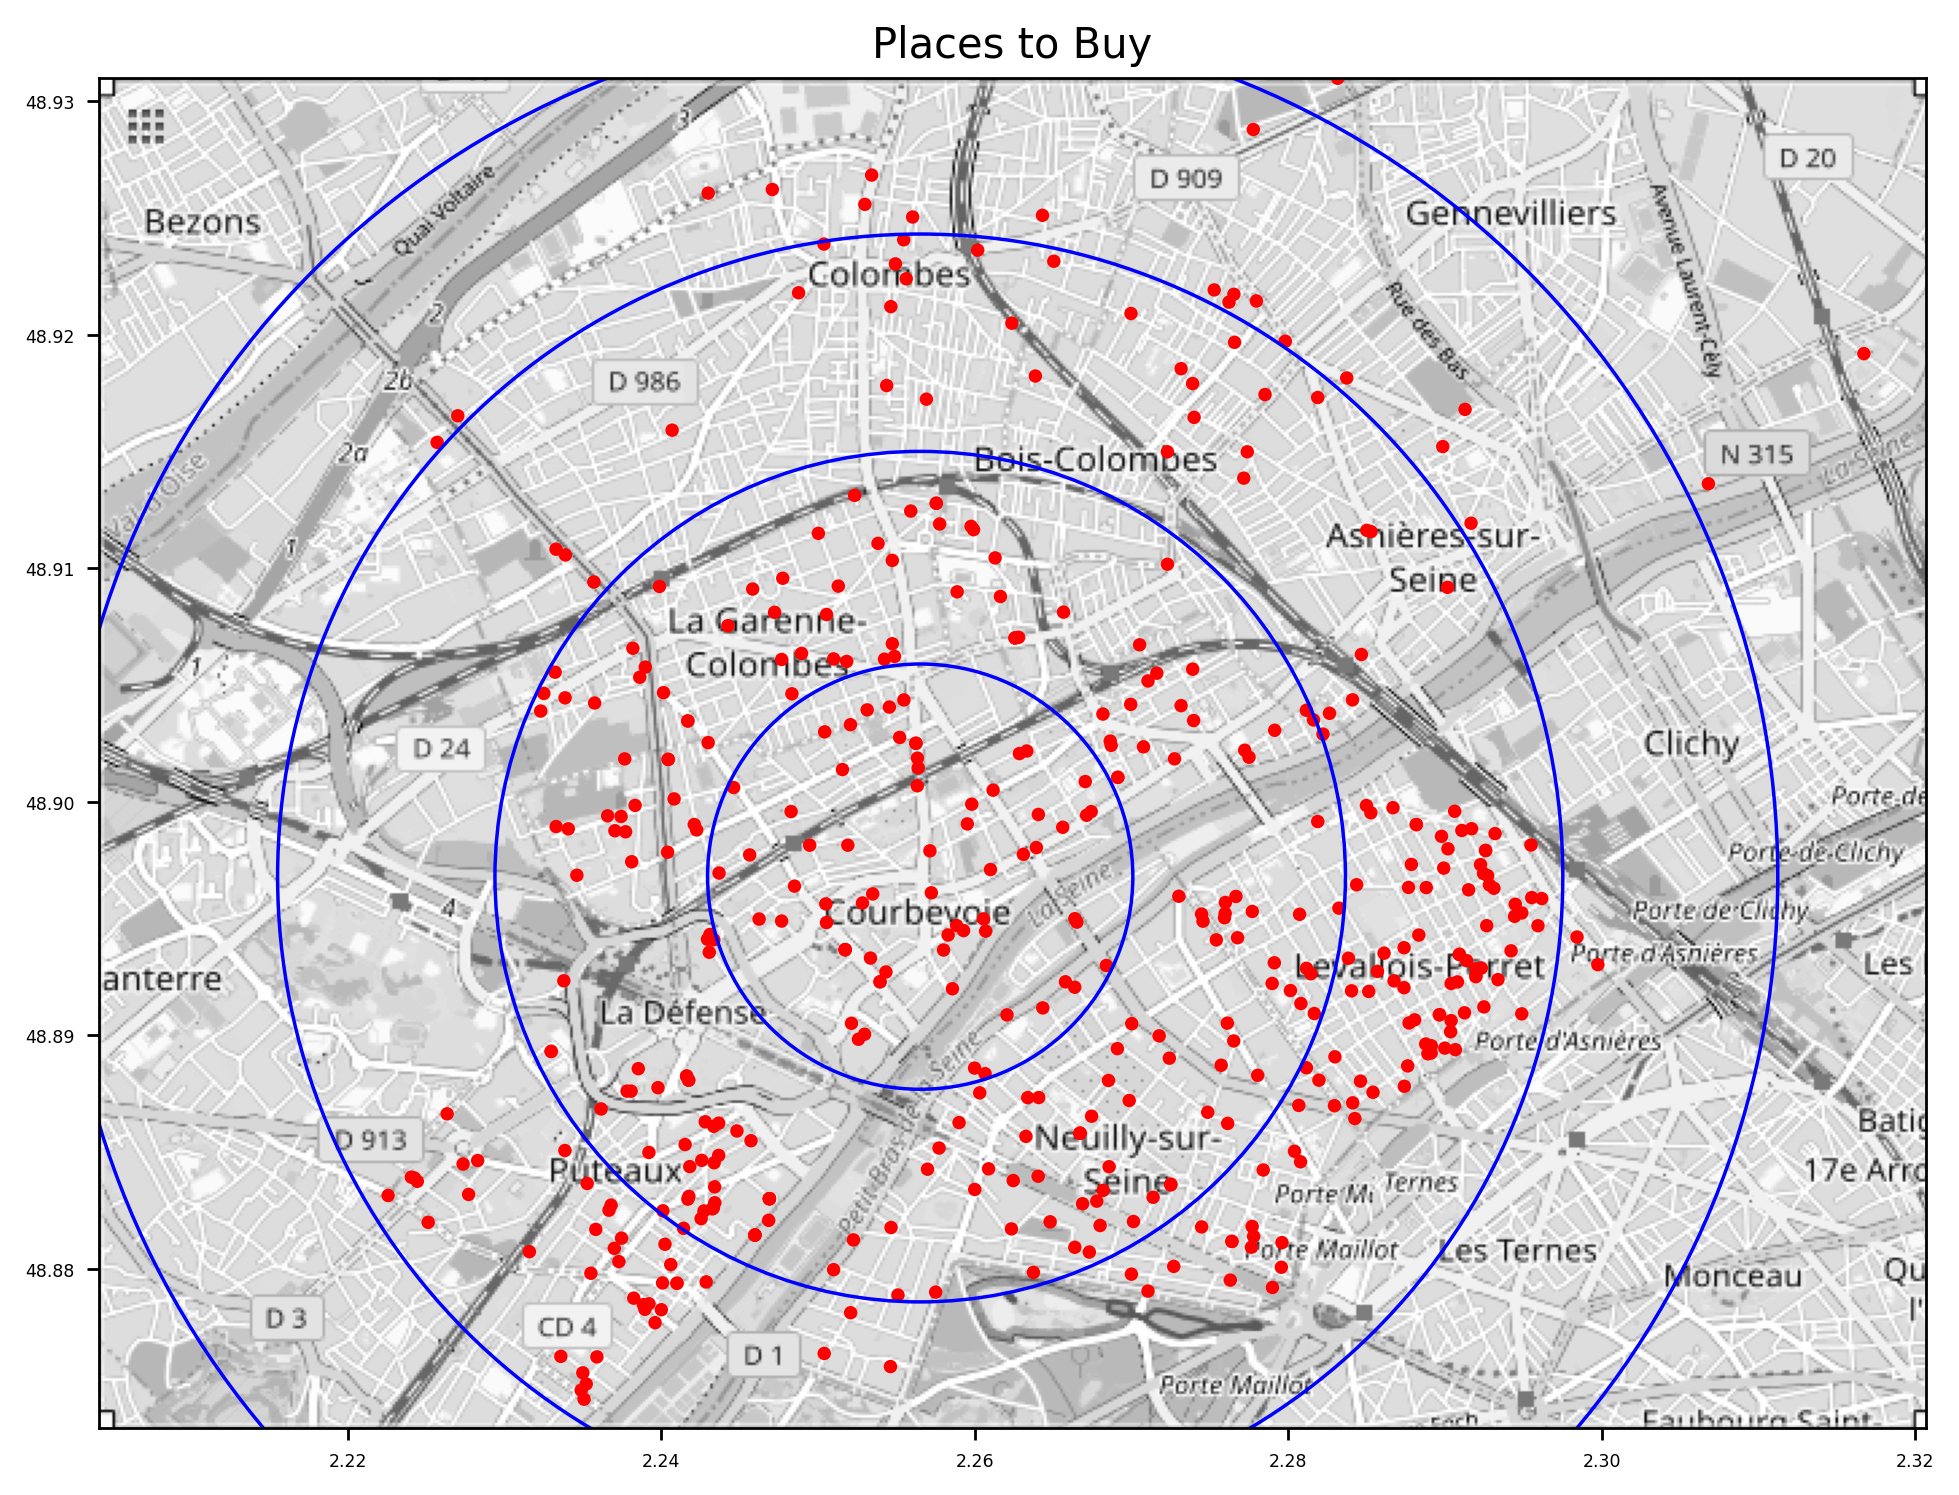

In [24]:
img=mpimg.imread("map.PNG")

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

gray = rgb2gray(img)

x_min = 2.2041 #min(df['long']) - 0.100
x_max = 2.3207 #max(df['long']) + 0.100
y_min = 48.8732 #min(df['lat']) - 0.100
y_max = 48.9310 #max(df['lat']) + 0.100

extent = (x_min, x_max, y_min, y_max)

plt.Figure(figsize=(679,515), dpi=50);
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9.43,7.15)
fig.set_dpi(250)
ax = plt.gca()
ax.set_aspect('auto')
plt.title('Places to Buy');

plt.imshow(gray, aspect='auto', extent = extent, cmap = plt.get_cmap('gray')) # Comment to remove background

plt.scatter(df['long'], df['lat'], s=15, alpha=1, edgecolors='none', c='red') # COMMENT TO REMOVE BLACK POINTS

plt.scatter(2.256520, 48.896801, s=244000, c='none', edgecolors='blue') # 4km_Radius
plt.scatter(2.256520, 48.896801, s=137000, c='none', edgecolors='blue') # 3km_Radius
plt.scatter(2.256520, 48.896801, s=60000, c='none', edgecolors='blue') # 2km_Radius
plt.scatter(2.256520, 48.896801, s=15000, c='none', edgecolors='blue') # 1km_Radius

#plt.scatter(2.311173, 48.897086, s=15, c='red', edgecolors='none') # 4km_Point
#plt.scatter(2.297494, 48.897008, s=15, c='red', edgecolors='none') # 3km_Point
#plt.scatter(2.283816, 48.896928, s=15, c='red', edgecolors='none') # 2km_Point
#plt.scatter(2.270135, 48.896850, s=15, c='red', edgecolors='none') # 1km_Point

# 1km = 48.896850, 2.270135
# 2km = 48.896928, 2.283816
# 3km = 48.897008, 2.297494
# 4km = 48.897086, 2.311173

plt.xlim((x_min,x_max))
plt.ylim((y_min,y_max))

plt.xticks(size=5)
plt.yticks(size=5)

#plt.savefig(path + '/heatmaps/' + 'global.png' , transparent=True);
plt.show()
#plt.close()

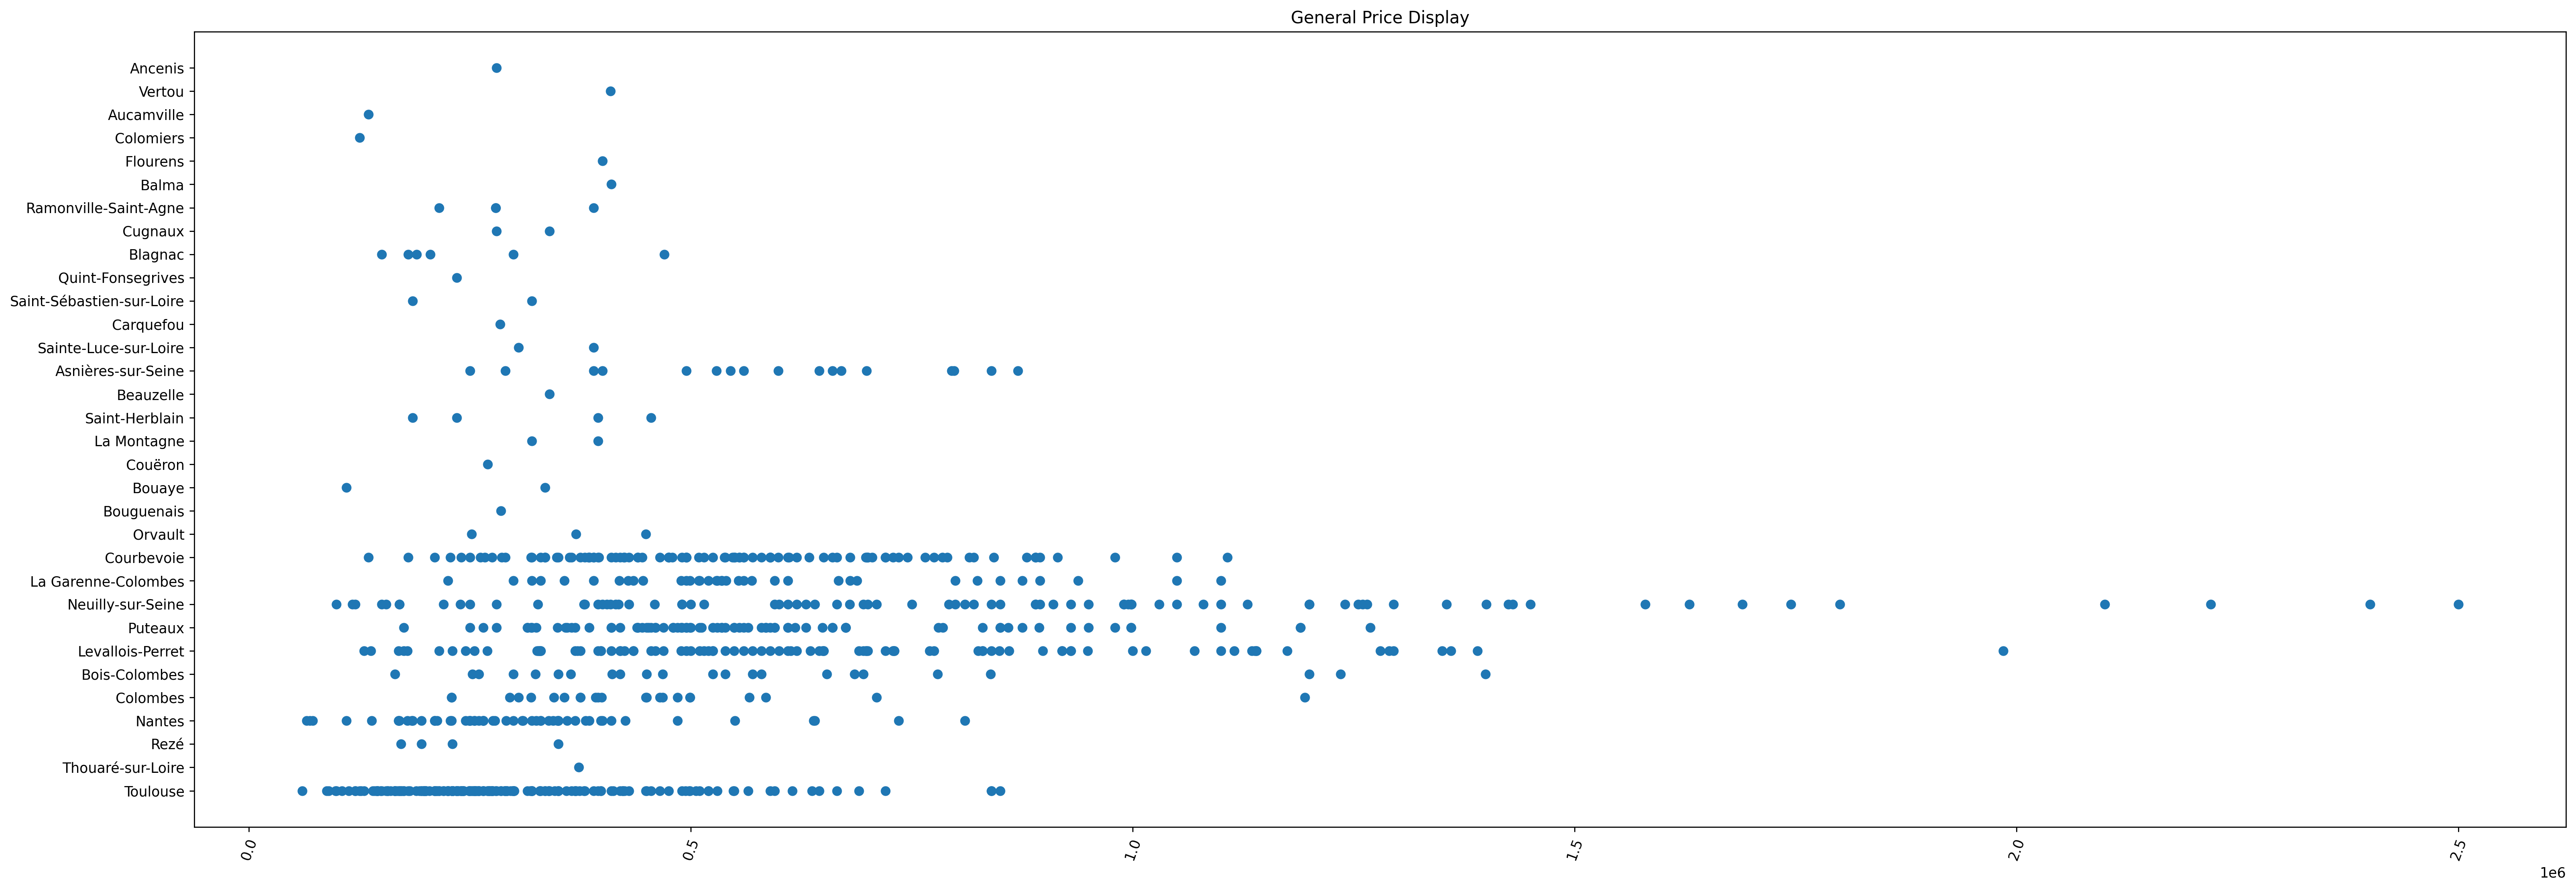

In [25]:
fig = plt.gcf()
fig.set_size_inches(30.5, 10.5)
fig.set_dpi(250)
plt.title("General Price Display")
plt.xticks(rotation=70)
plt.scatter(df['price'], df['city'])

plt.show()

In [26]:
# Predicition Model

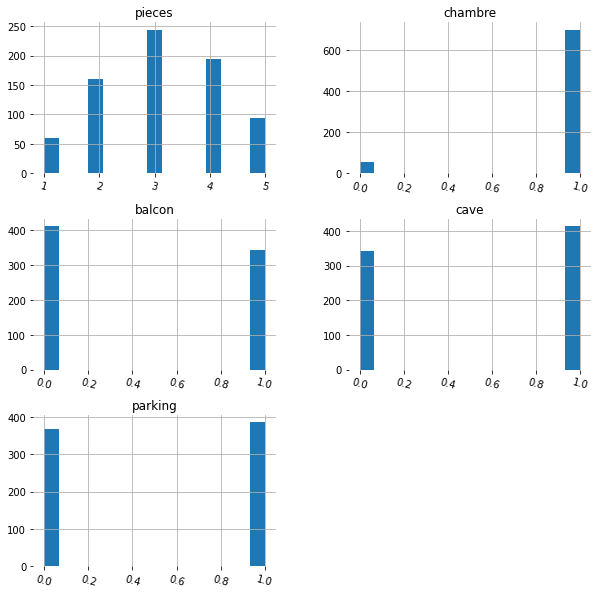

In [27]:
df1=df[['pieces', 'chambre', 'balcon', 'cave', 'parking']]
h = df1.hist(bins=15,figsize=(10,10),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

In [28]:
# Estimation per city

In [29]:
estimation_city = pd.DataFrame({
    "City" : [],
    "sqrt_meter" : [],
    "price" : [],
    "Average Price" : [],
    "Intercept" : [],
    "Coefficient" : []
})

Text(0.5, 0, 'Surface en m2')

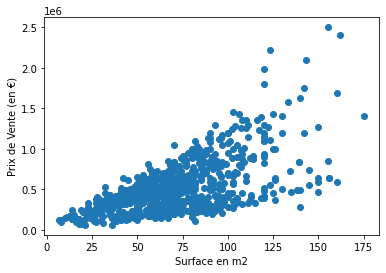

In [30]:
plt.scatter(df['sqrt_meter'], df['price'])

plt.ylabel("Prix de Vente (en €)")
plt.xlabel("Surface en m2")

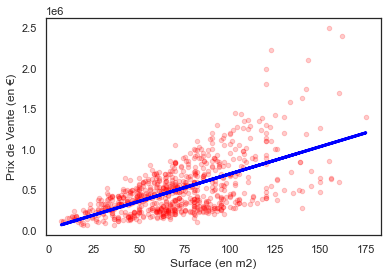

Estimation : 357806.5446495944
Average Price for Test Data: 502976.238
Intercept: 20025.729839571635
Coefficient: 6755.6162962004555


In [31]:
# Exemple Explicatif du fonctionnement de LinearRegression()

x2 = df['sqrt_meter'].to_list()
x1 = [1]*len(df)

X = np.column_stack((x1,x2))

y = df['price'].to_list()

def predict_get_value(i) :
    r = regr.predict([[1,i]])
    
    return r[-1]

regr = linear_model.LinearRegression()
regr.fit(X, y)
predict_line = regr.predict(X) #[[1,220]]

sns.set(style="white", font_scale=1)

plt.scatter(x2, y, color='red', s=20, marker='o', alpha=.2)
plt.plot(x2, predict_line, color='blue', linewidth=3)
plt.xlabel("Surface (en m2)")
plt.ylabel("Prix de Vente (en €)")
plt.show()

print('Estimation : {}'.format(predict_get_value(50))) # Obtention de la valeur pour un métrage spécifique
print ("Average Price for Test Data: {:.3f}".format(df['price'].mean()))
print('Intercept: {}'.format(regr.intercept_))
print('Coefficient: {}'.format(regr.coef_[1]))

r = estimation_city.shape[0]
estimation_city.loc[r] = ['General','50',predict_get_value(20),df['price'].mean(),regr.intercept_,regr.coef_[1]]

In [32]:
city_list = df['city'].unique()
city_list

array(['Toulouse', 'Thouaré-sur-Loire', 'Rezé', 'Nantes', 'Colombes',
       'Bois-Colombes', 'Levallois-Perret', 'Puteaux',
       'Neuilly-sur-Seine', 'La Garenne-Colombes', 'Courbevoie',
       'Orvault', 'Bouguenais', 'Bouaye', 'Couëron', 'La Montagne',
       'Saint-Herblain', 'Beauzelle', 'Asnières-sur-Seine',
       'Sainte-Luce-sur-Loire', 'Carquefou', 'Saint-Sébastien-sur-Loire',
       'Quint-Fonsegrives', 'Blagnac', 'Cugnaux', 'Ramonville-Saint-Agne',
       'Balma', 'Flourens', 'Colomiers', 'Aucamville', 'Vertou',
       'Ancenis'], dtype=object)

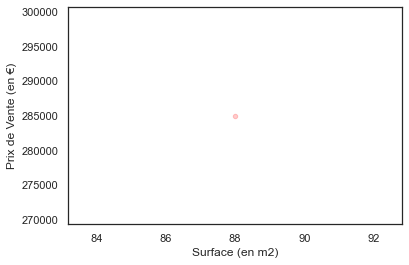

Bouguenais
Estimation : 285000.0
Average Price for Test Data: 285000.000
Intercept: 285000.0
Coefficient: 0.0


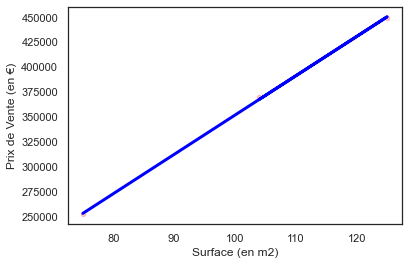

Orvault
Estimation : 35903.22580645172
Average Price for Test Data: 357000.000
Intercept: -43054.99735589622
Coefficient: 3947.911158117397


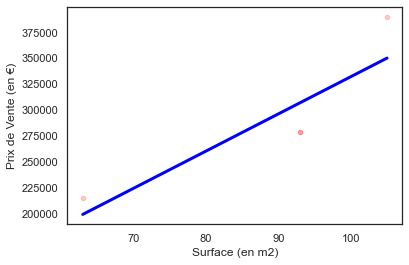

Ramonville-Saint-Agne
Estimation : 44384.7352024922
Average Price for Test Data: 290750.000
Intercept: -27546.728971962642
Coefficient: 3596.573208722742


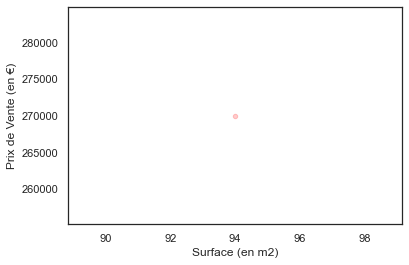

Couëron
Estimation : 270000.0
Average Price for Test Data: 270000.000
Intercept: 270000.0
Coefficient: 0.0


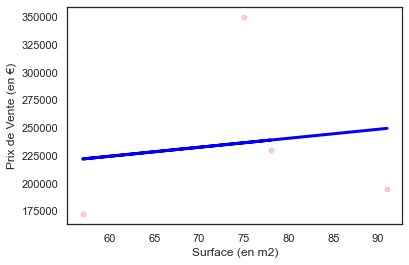

Rezé
Estimation : 191964.3694267516
Average Price for Test Data: 236722.500
Intercept: 175762.3312101911
Coefficient: 810.1019108280253


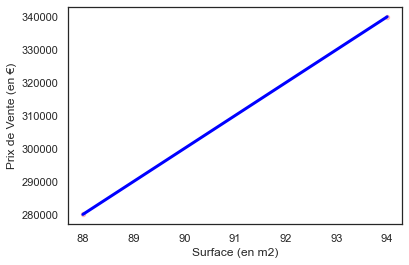

Cugnaux
Estimation : -399999.9999999997
Average Price for Test Data: 310000.000
Intercept: -599999.9999999997
Coefficient: 9999.999999999996


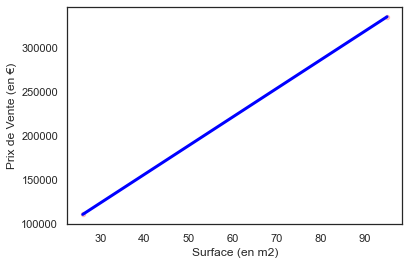

Bouaye
Estimation : 90434.78260869568
Average Price for Test Data: 222500.000
Intercept: 25217.391304347868
Coefficient: 3260.8695652173906


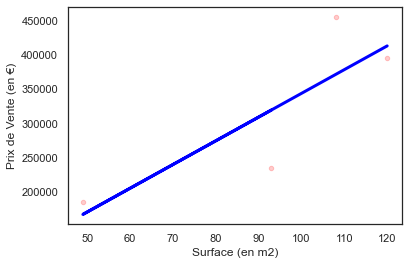

Saint-Herblain
Estimation : 66924.54136379353
Average Price for Test Data: 317500.000
Intercept: -2199.7230875737732
Coefficient: 3456.213222568365


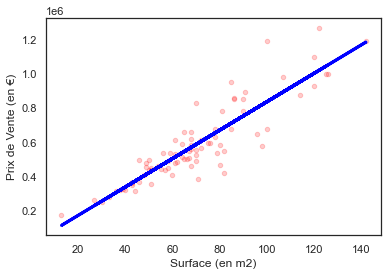

Puteaux
Estimation : 171658.7299278387
Average Price for Test Data: 581670.732
Intercept: 5588.173514318187
Coefficient: 8303.527820676025


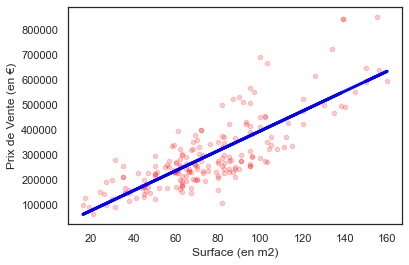

Toulouse
Estimation : 75869.8142757633
Average Price for Test Data: 294916.701
Intercept: -3614.87275255617
Coefficient: 3974.2343514159734


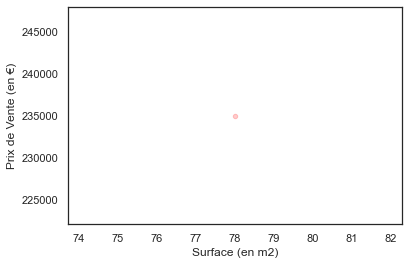

Quint-Fonsegrives
Estimation : 235000.0
Average Price for Test Data: 235000.000
Intercept: 235000.0
Coefficient: 0.0


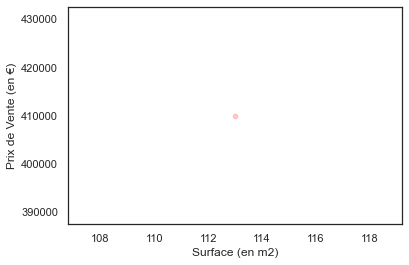

Balma
Estimation : 410000.0
Average Price for Test Data: 410000.000
Intercept: 410000.0
Coefficient: 0.0


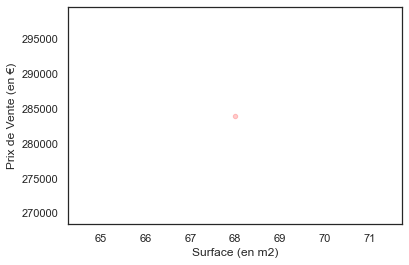

Carquefou
Estimation : 284000.0
Average Price for Test Data: 284000.000
Intercept: 284000.0
Coefficient: 0.0


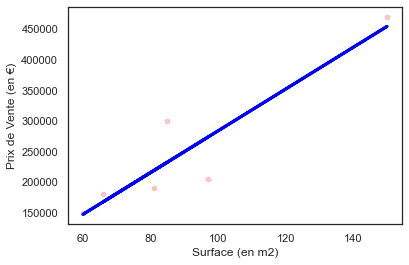

Blagnac
Estimation : 10434.220168870495
Average Price for Test Data: 248916.667
Intercept: -57866.24183527162
Coefficient: 3415.0231002071055


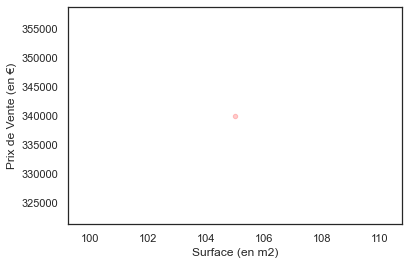

Beauzelle
Estimation : 340000.0
Average Price for Test Data: 340000.000
Intercept: 340000.0
Coefficient: 0.0


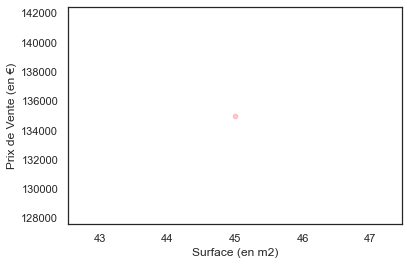

Aucamville
Estimation : 135000.0
Average Price for Test Data: 135000.000
Intercept: 135000.0
Coefficient: 0.0


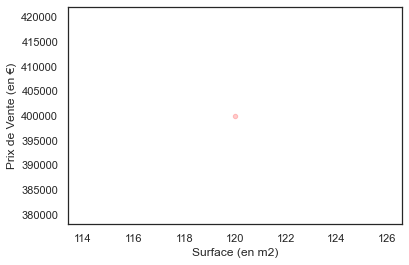

Flourens
Estimation : 400000.0
Average Price for Test Data: 400000.000
Intercept: 400000.0
Coefficient: 0.0


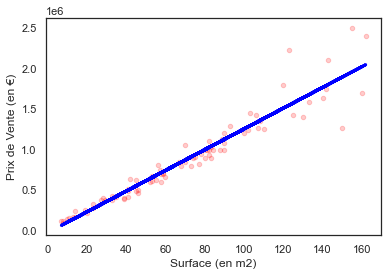

Neuilly-sur-Seine
Estimation : 230956.61146204174
Average Price for Test Data: 865435.904
Intercept: -24559.06660030922
Coefficient: 12775.783903117548


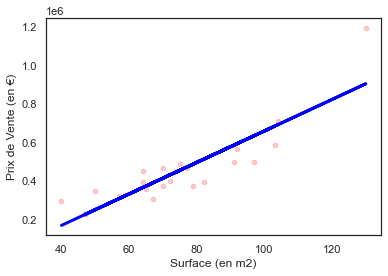

Colombes
Estimation : 4696.008282224706
Average Price for Test Data: 451565.217
Intercept: -158836.0809701035
Coefficient: 8176.604462616411


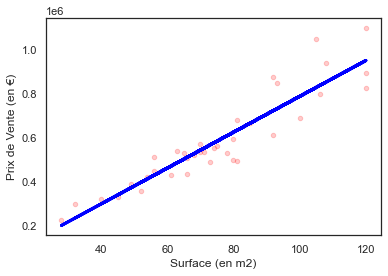

La Garenne-Colombes
Estimation : 134895.15842128507
Average Price for Test Data: 583648.649
Intercept: -28287.928934119875
Coefficient: 8159.1543677702475


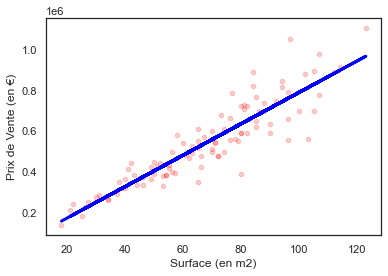

Courbevoie
Estimation : 171754.09617163296
Average Price for Test Data: 539919.192
Intercept: 17344.672409682767
Coefficient: 7720.471188097509


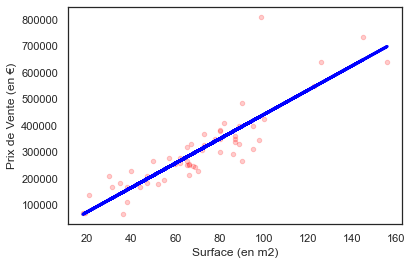

Nantes
Estimation : 74503.38331084164
Average Price for Test Data: 306123.214
Intercept: -17194.817711377284
Coefficient: 4584.910051110946


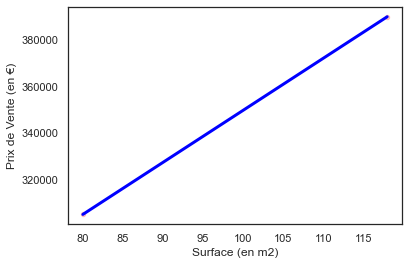

Sainte-Luce-sur-Loire
Estimation : 170789.4736842106
Average Price for Test Data: 347500.000
Intercept: 126052.63157894745
Coefficient: 2236.842105263157


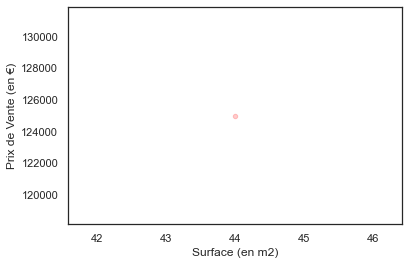

Colomiers
Estimation : 125000.0
Average Price for Test Data: 125000.000
Intercept: 125000.0
Coefficient: 0.0


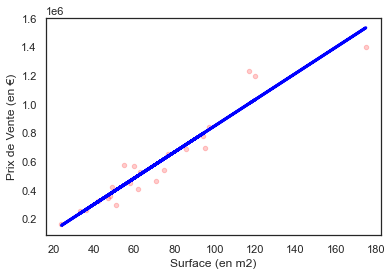

Bois-Colombes
Estimation : 118800.78763786191
Average Price for Test Data: 585391.304
Intercept: -63864.43592518789
Coefficient: 9133.26117815249


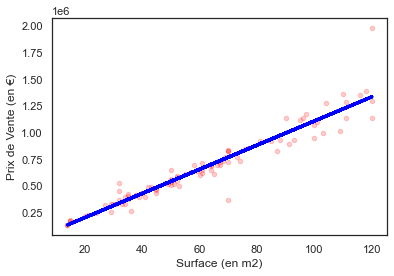

Levallois-Perret
Estimation : 202832.499265902
Average Price for Test Data: 669210.526
Intercept: -23970.22696772637
Coefficient: 11340.13631168142


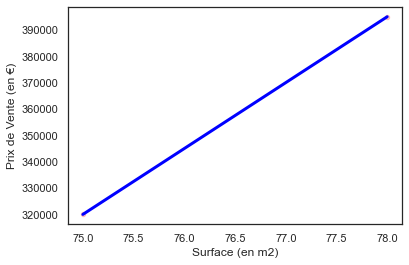

La Montagne
Estimation : -1054999.9999999993
Average Price for Test Data: 357500.000
Intercept: -1554999.999999999
Coefficient: 24999.99999999999


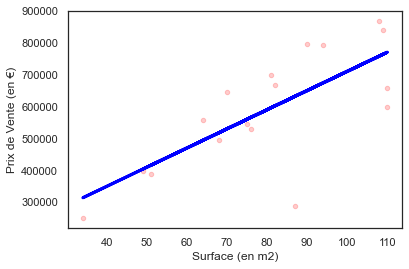

Asnières-sur-Seine
Estimation : 230665.45215540033
Average Price for Test Data: 590294.118
Intercept: 110553.71711889358
Coefficient: 6005.586751825338


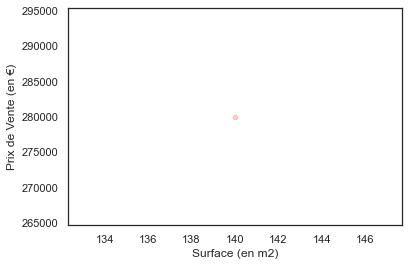

Ancenis
Estimation : 280000.0
Average Price for Test Data: 280000.000
Intercept: 280000.0
Coefficient: 0.0


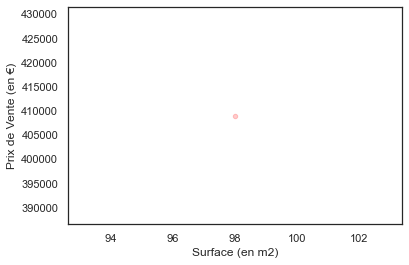

Vertou
Estimation : 409000.0
Average Price for Test Data: 409000.000
Intercept: 409000.0
Coefficient: 0.0


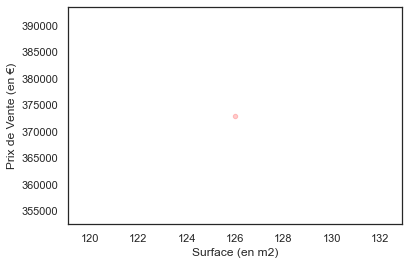

Thouaré-sur-Loire
Estimation : 373000.0
Average Price for Test Data: 373000.000
Intercept: 373000.0
Coefficient: 0.0


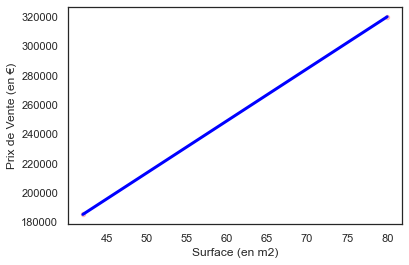

Saint-Sébastien-sur-Loire
Estimation : 106842.10526315798
Average Price for Test Data: 252500.000
Intercept: 35789.47368421065
Coefficient: 3552.6315789473665


In [33]:
for city_id in set(df['city']):
    df_filtered = df.loc[df['city']==city_id,:] 


    x2 = df_filtered['sqrt_meter'].to_list()
    x1 = [1]*len(df_filtered)

    X = np.column_stack((x1,x2))

    y = df_filtered['price'].to_list()

    def predict_get_value(i) :
        r = regr.predict([[1,i]])
    
        return r[-1]

    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    predict_line = regr.predict(X) #[[1,220]]

    sns.set(style="white", font_scale=1)

    plt.scatter(x2, y, color='red', s=20, marker='o', alpha=.2)
    plt.plot(x2, predict_line, color='blue', linewidth=3)
    plt.xlabel("Surface (en m2)")
    plt.ylabel("Prix de Vente (en €)")
    plt.show()

    print(city_id)
    print('Estimation : {}'.format(predict_get_value(20))) # Obtention de la valeur pour un métrage spécifique
    print ("Average Price for Test Data: {:.3f}".format(df_filtered['price'].mean()))
    print('Intercept: {}'.format(regr.intercept_))
    print('Coefficient: {}'.format(regr.coef_[1]))

    r = estimation_city.shape[0]
    estimation_city.loc[r] = [city_id,'20',predict_get_value(20),df_filtered['price'].mean(),regr.intercept_,regr.coef_[1]]

In [34]:
estimation_city

City sqrt_meter         price  Average Price  \
0                     General         50  1.551381e+05  502976.238411   
1                  Bouguenais         20  2.850000e+05  285000.000000   
2                     Orvault         20  3.590323e+04  357000.000000   
3       Ramonville-Saint-Agne         20  4.438474e+04  290750.000000   
4                     Couëron         20  2.700000e+05  270000.000000   
5                        Rezé         20  1.919644e+05  236722.500000   
6                     Cugnaux         20 -4.000000e+05  310000.000000   
7                      Bouaye         20  9.043478e+04  222500.000000   
8              Saint-Herblain         20  6.692454e+04  317500.000000   
9                     Puteaux         20  1.716587e+05  581670.731707   
10                   Toulouse         20  7.586981e+04  294916.700508   
11          Quint-Fonsegrives         20  2.350000e+05  235000.000000   
12                      Balma         20  4.100000e+05  410000.000000   
13                  Carquefou         20  2.840000e+05  284000.000000   
14                    Blagnac         20  1.043422e+04  248916.666667   
15                  Beauzelle         20  3.400000e+05  340000.000000   
16                 Aucamville         20  1.350000e+05  135000.000000   
17                   Flourens         20  4.000000e+05  400000.000000   
18          Neuilly-sur-Seine         20  2.309566e+05  865435.903614   
19                   Colombes         20  4.696008e+03  451565.217391   
20        La Garenne-Colombes         20  1.348952e+05  583648.648649   
21                 Courbevoie         20  1.717541e+05  539919.191919   
22                     Nantes         20  7.450338e+04  306123.214286   
23      Sainte-Luce-sur-Loire         20  1.707895e+05  347500.000000   
24                  Colomiers         20  1.250000e+05  125000.000000   
25              Bois-Colombes         20  1.188008e+05  585391.304348   
26           Levallois-Perret         20  2.028325e+05  669210.526316   
27                La Montagne         20 -1.055000e+06  357500.000000   
28         Asnières-sur-Seine         20  2.306655e+05  590294.117647   
29                    Ancenis         20  2.800000e+05  280000.000000   
30                     Vertou         20  4.090000e+05  409000.000000   
31          Thouaré-sur-Loire         20  3.730000e+05  373000.000000   
32  Saint-Sébastien-sur-Loire         20  1.068421e+05  252500.000000   

       Intercept   Coefficient  
0   2.002573e+04   6755.616296  
1   2.850000e+05      0.000000  
2  -4.305500e+04   3947.911158  
3  -2.754673e+04   3596.573209  
4   2.700000e+05      0.000000  
5   1.757623e+05    810.101911  
6  -6.000000e+05  10000.000000  
7   2.521739e+04   3260.869565  
8  -2.199723e+03   3456.213223  
9   5.588174e+03   8303.527821  
10 -3.614873e+03   3974.234351  
11  2.350000e+05      0.000000  
12  4.100000e+05      0.000000  
13  2.840000e+05      0.000000  
14 -5.786624e+04   3415.023100  
15  3.400000e+05      0.000000  
16  1.350000e+05      0.000000  
17  4.000000e+05      0.000000  
18 -2.455907e+04  12775.783903  
19 -1.588361e+05   8176.604463  
20 -2.828793e+04   8159.154368  
21  1.734467e+04   7720.471188  
22 -1.719482e+04   4584.910051  
23  1.260526e+05   2236.842105  
24  1.250000e+05      0.000000  
25 -6.386444e+04   9133.261178  
26 -2.397023e+04  11340.136312  
27 -1.555000e+06  25000.000000  
28  1.105537e+05   6005.586752  
29  2.800000e+05      0.000000  
30  4.090000e+05      0.000000  
31  3.730000e+05      0.000000  
32  3.578947e+04   3552.631579

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


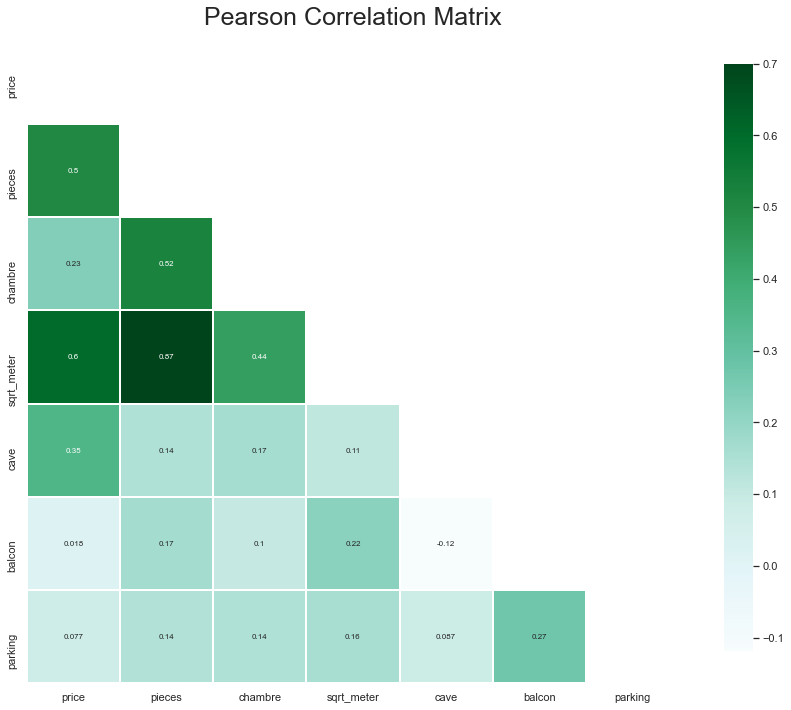

In [35]:
features = ['price','pieces','chambre','sqrt_meter','cave','balcon','parking']

mask = np.zeros_like(df[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

In [36]:
df.head()

title  \
0     Vente maison 138 m² Toulouse (31200) 494.000 €   
1  Vente appartement 4 pièces 83 m² Toulouse (310...   
2  Vente appartement 3 pièces 50 m² Toulouse (312...   
3  Vente appartement 4 pièces 95 m² Toulouse (310...   
4  Vente appartement 2 pièces 30 m² Toulouse (313...   

                                                link   price      city  \
0  https://www.pap.fr/annonces/maison-toulouse-31...  494000  Toulouse   
1  https://www.pap.fr/annonces/appartement-toulou...  369000  Toulouse   
2  https://www.pap.fr/annonces/appartement-toulou...  253000  Toulouse   
3  https://www.pap.fr/annonces/appartement-toulou...  565000  Toulouse   
4  https://www.pap.fr/annonces/appartement-toulou...  120000  Toulouse   

                                           free_text  transport  \
0  Toulouse (31200) 5 pièces 4 chambres 138 m² Te...        NaN   
1  Toulouse (31000) 4 pièces 3 chambres 83 m² 4.4...        NaN   
2  Toulouse (31000) 3 pièces 2 chambres 50 m² 5.0...        NaN   
3  Toulouse (31000) 4 pièces 3 chambres 95 m² 5.9...        NaN   
4  Toulouse (31300) 2 pièces 1 chambre 30 m² 4.00...        NaN   

                    createdAt                   updatedAt        lat  \
0  2021-07-09 23:42:39.727+02  2021-07-09 23:42:39.727+02  43.660005   
1  2021-07-09 23:41:26.394+02  2021-07-09 23:41:26.394+02  43.612119   
2  2021-07-09 23:41:17.291+02  2021-07-09 23:41:17.291+02  43.616971   
3  2021-07-09 23:39:44.821+02  2021-07-09 23:39:44.821+02  43.605186   
4  2021-07-09 23:39:34.712+02  2021-07-09 23:39:34.712+02  43.611688   

       long  ...        date pieces  chambre  sqrt_meter  mean_price_sqrtmtr  \
0  1.436433  ...  05/07/2021    5.0        1         138         3579.710145   
1  1.451790  ...  06/07/2021    4.0        1          83         4445.783133   
2  1.442698  ...  06/07/2021    3.0        1          50         5060.000000   
3  1.425472  ...  08/07/2021    4.0        1          95         5947.368421   
4  1.394127  ...  08/07/2021    2.0        1          30         4000.000000   

   cave  balcon  parking    distance  code-postal  
0     0       1        0  589.098230        31200  
1     0       1        1  594.094590        31000  
2     0       0        0  593.716149        31000  
3     1       1        1  595.307545        31000  
4     0       1        1  595.150034        31300  

[5 rows x 21 columns]

In [37]:
df['free_text'][0]

"Toulouse (31200) 5 pièces 4 chambres 138\xa0m² Terrain 610\xa0m² 3.580 € le m² Voir l'adresse du bien sur une carte Quartier calme de Croix Bénite. Maison individuelle contemporaine de 2003 en excellent état, sur une parcelle de 610m² arborée avec piscine 8x4, arrosage intégré, puits. Superficie totale 138m² habitables en R+1 ; garage de 24 m² avec mezzanine de rangement de 16m² ; 90m² de terrasses dont une couverte de 8m² ; chauffage central gaz de ville et poêle à bois. Proximité commerces Aucamville ; accès rapides métro, bus, périphérique ; Aéroport et gare 15mn. Descriptif rez-de-chaussée : Entrée et dégagement Pièce de vie de 47m² (salle à manger salon et cuisine) avec poêle à bois 1 cellier 1 chambre de 12m² avec salle d’eau, douche et double vasque 1 wc. Descriptif R+1 (parquet chêne massif) : Dégagement 3 chambres avec placard, entre 12 et 14m² 1 wc 1 salle de bain de 9,5m² avec double vasque, baignoire et douche. Quartier calme de Croix Bénite. Maison individuelle contempora

In [38]:
df.iloc[0,:]

title                    Vente maison 138 m² Toulouse (31200) 494.000 €
link                  https://www.pap.fr/annonces/maison-toulouse-31...
price                                                            494000
city                                                           Toulouse
free_text             Toulouse (31200) 5 pièces 4 chambres 138 m² Te...
transport                                                           NaN
createdAt                                    2021-07-09 23:42:39.727+02
updatedAt                                    2021-07-09 23:42:39.727+02
lat                                                           43.660005
long                                                           1.436433
ref                                                     Réf. : D81/1975
date                                                         05/07/2021
pieces                                                              5.0
chambre                                                         

In [39]:
# Graph avec les points et toutes les regressions linéaires 
# Regression multiples : Avec impacts : Pieces, size, balcon, cave, parking. [Polynome 5e degré]

In [40]:
test = df.loc[df['city'] == 'Courbevoie', :]
x = test['sqrt_meter'].values
y = test['price'].values
z = test['pieces'].values

Text(0, 0.5, 'Price')

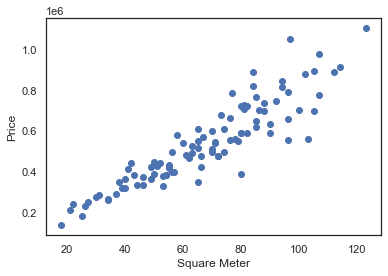

In [41]:
plt.scatter(x, y)
plt.xlabel('Square Meter')
plt.ylabel('Price')

In [42]:
# Vérification des dimensions
print(x.shape)
print(y.shape)

# redimensionner y
x = x.reshape(x.shape[0], 1)
y = y.reshape(y.shape[0], 1)
z = z.reshape(z.shape[0], 1)
print(y.shape)

(99,)
(99,)
(99, 1)


In [43]:
# Création de la matrice X, inclus le biais
X = np.hstack((x, np.ones((x.shape[0], 1))))
print(X.shape)
print(X[:10])

(99, 2)
[[ 18.   1.]
 [ 67.   1.]
 [ 71.   1.]
 [ 34.   1.]
 [ 38.   1.]
 [ 26.   1.]
 [ 70.   1.]
 [ 56.   1.]
 [107.   1.]
 [ 77.   1.]]


In [44]:
# Initialisation du vecteur theta aléatoire
theta = np.random.randn(2,1)
theta

array([[-1.63002526],
       [ 1.36104552]])

In [45]:
## Modele linéaire
def model(X, theta):
    return X.dot(theta)

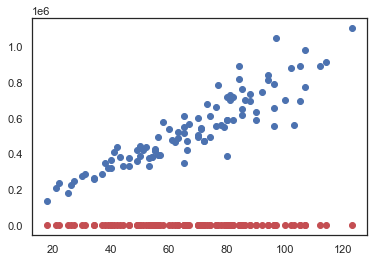

In [46]:
plt.scatter(x[:,0], y)
plt.scatter(x[:,0], model(X, theta), c='r')

In [47]:
## Fonction Cout : Erreur Quadratique Moyenne

def cost_function(X, y, theta):
    m = len(y)
    return 1/(2*m) * np.sum((model(X, theta) - y)**2)

cost_function(X, y, theta)

166189108478.0353

In [48]:
# Descente de gradient

In [49]:
def grad(X, y, theta):
    m = len(y)
    return 1/m * X.T.dot(model(X, theta) - y)

In [50]:
def gradient_descent(X, y, theta, learning_rate, n_iterations):
    cost_history = np.zeros(n_iterations)
    
    for i in range(0, n_iterations):
        theta = theta - learning_rate * grad(X, y, theta) # Mise à jour de theta
        cost_history[i] = cost_function(X, y, theta) # Enregistrement valeur theta
    
    return theta, cost_history

In [51]:
## Phase d'entrainement

n_iterations = 1000
learning_rate = 0.0001

theta_final, cost_history = gradient_descent(X, y, theta, learning_rate, n_iterations)

theta_final # parametres du model entrainé

array([[7944.84882316],
       [ 293.37251173]])

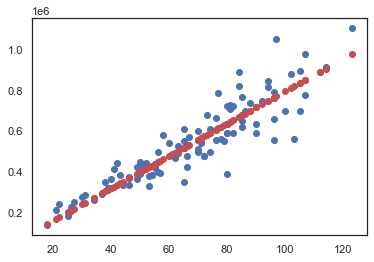

In [52]:
# création d'un vecteur prediction
predictions = model(X, theta_final)

# Afficher resultat prediction
plt.scatter(x[:,0], y)
plt.scatter(x[:,0], predictions, c='r')

In [53]:
df.head()

title  \
0     Vente maison 138 m² Toulouse (31200) 494.000 €   
1  Vente appartement 4 pièces 83 m² Toulouse (310...   
2  Vente appartement 3 pièces 50 m² Toulouse (312...   
3  Vente appartement 4 pièces 95 m² Toulouse (310...   
4  Vente appartement 2 pièces 30 m² Toulouse (313...   

                                                link   price      city  \
0  https://www.pap.fr/annonces/maison-toulouse-31...  494000  Toulouse   
1  https://www.pap.fr/annonces/appartement-toulou...  369000  Toulouse   
2  https://www.pap.fr/annonces/appartement-toulou...  253000  Toulouse   
3  https://www.pap.fr/annonces/appartement-toulou...  565000  Toulouse   
4  https://www.pap.fr/annonces/appartement-toulou...  120000  Toulouse   

                                           free_text  transport  \
0  Toulouse (31200) 5 pièces 4 chambres 138 m² Te...        NaN   
1  Toulouse (31000) 4 pièces 3 chambres 83 m² 4.4...        NaN   
2  Toulouse (31000) 3 pièces 2 chambres 50 m² 5.0...        NaN   
3  Toulouse (31000) 4 pièces 3 chambres 95 m² 5.9...        NaN   
4  Toulouse (31300) 2 pièces 1 chambre 30 m² 4.00...        NaN   

                    createdAt                   updatedAt        lat  \
0  2021-07-09 23:42:39.727+02  2021-07-09 23:42:39.727+02  43.660005   
1  2021-07-09 23:41:26.394+02  2021-07-09 23:41:26.394+02  43.612119   
2  2021-07-09 23:41:17.291+02  2021-07-09 23:41:17.291+02  43.616971   
3  2021-07-09 23:39:44.821+02  2021-07-09 23:39:44.821+02  43.605186   
4  2021-07-09 23:39:34.712+02  2021-07-09 23:39:34.712+02  43.611688   

       long  ...        date pieces  chambre  sqrt_meter  mean_price_sqrtmtr  \
0  1.436433  ...  05/07/2021    5.0        1         138         3579.710145   
1  1.451790  ...  06/07/2021    4.0        1          83         4445.783133   
2  1.442698  ...  06/07/2021    3.0        1          50         5060.000000   
3  1.425472  ...  08/07/2021    4.0        1          95         5947.368421   
4  1.394127  ...  08/07/2021    2.0        1          30         4000.000000   

   cave  balcon  parking    distance  code-postal  
0     0       1        0  589.098230        31200  
1     0       1        1  594.094590        31000  
2     0       0        0  593.716149        31000  
3     1       1        1  595.307545        31000  
4     0       1        1  595.150034        31300  

[5 rows x 21 columns]